# Singapore rent analysis project
### *Key objectives*:
### * Analysis of reliable rental data to understand the Singapore rental market and support further decisions on our residential rent with evidence-based insights.
### * Identification of suitable areas in Singapore will allow us to narrow the range of search, reduce non-productive effort and stress level, simplify the process of adaptation in the process of relocation.
### * Analysis of key Trends, allowing us to focus on the choice of living area and rental option.

## 1. Data aquisition and pre-processing

### 1.1 Importing necessary libraries

In [1]:
import os
import glob
import json
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import seaborn as sns
from distfit import distfit
from joypy import joyplot
from ratelimit import limits, RateLimitException
from backoff import on_exception, expo
import time
import geopandas
import folium as fs

##### installing  __[client for Singapore OpenMap API](https://pypi.org/project/pyonemap/)__

In [2]:
from pyonemap import OneMap

##### installing official __[Token Package for API](https://pypi.org/project/ura-api/0.0.6/)__ of the Urban Redevelopment Authority of Singapore (URA) 

In [3]:
from ura_api import ura_api

In [4]:
#credentials for API access
from dotenv import load_dotenv
load_dotenv()

ura_skey = os.getenv('URA_KEY')
onemap_mail = os.getenv('ONEMAP_EMAIL')
onemap_password = os.getenv('ONEMAP_PASSWORD')

### 1.2 Composing dataframe from json files dowloaded with official URA API Client

In [5]:
ura = ura_api.ura_api(ura_skey)

periods = ['22q1', '22q2', '22q3', '22q4', '23q1', '23q2', '23q3', '23q4'] #periods from 1st quarter of 2022 through 4th quarter of 2023
df1 = pd.DataFrame()

for period in periods:
    data = ura.private_residential_properties_rental_contract(period) # URA API for the data on private rental contracts
    df2 = pd.json_normalize(data, record_path = ['rental'], meta=['project', 'street', 'x', 'y'], errors='ignore') #flattening the data
    df1 = pd.concat([df1, df2])

In [6]:
df1

areaSqm leaseDate           propertyType district   areaSqft  \
0      120-130      0122  Non-landed Properties       15  1300-1400   
1      210-220      0122  Non-landed Properties       15  2300-2400   
2      120-130      0222  Non-landed Properties       15  1300-1400   
3      120-130      0322  Non-landed Properties       15  1300-1400   
4      260-270      0222  Non-landed Properties       15  2800-2900   
...        ...       ...                    ...      ...        ...   
19812  100-110      1123  Executive Condominium       19  1000-1100   
19813   90-100      1223  Executive Condominium       19  1000-1100   
19814    80-90      1123  Executive Condominium       19    800-900   
19815   90-100      1123  Executive Condominium       19  1000-1100   
19816    70-80      1023  Executive Condominium       19    800-900   

      noOfBedRoom  rent                   project         street            x  \
0               3  3600  ELLIOT AT THE EAST COAST    ELLIOT ROAD  38865.17182   
1               3  6200  ELLIOT AT THE EAST COAST    ELLIOT ROAD  38865.17182   
2               3  4000  ELLIOT AT THE EAST COAST    ELLIOT ROAD  38865.17182   
3               3  4500  ELLIOT AT THE EAST COAST    ELLIOT ROAD  38865.17182   
4               4  6200  ELLIOT AT THE EAST COAST    ELLIOT ROAD  38865.17182   
...           ...   ...                       ...            ...          ...   
19812           3  4300                     PRIVE  PUNGGOL FIELD  35969.63449   
19813           3  4350                     PRIVE  PUNGGOL FIELD  35969.63449   
19814           2  4000                     PRIVE  PUNGGOL FIELD  35969.63449   
19815           3  4200                     PRIVE  PUNGGOL FIELD  35969.63449   
19816           2  3800                     PRIVE  PUNGGOL FIELD  35969.63449   

                 y  
0      32621.92134  
1      32621.92134  
2      32621.92134  
3      32621.92134  
4      32621.92134  
...            ...  
19812    42560.406  
19813    42560.406  
19814    42560.406  
19815    42560.406  
19816    42560.406  

[179398 rows x 11 columns]

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179398 entries, 0 to 19816
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   areaSqm       179398 non-null  object
 1   leaseDate     179398 non-null  object
 2   propertyType  179398 non-null  object
 3   district      179398 non-null  object
 4   areaSqft      179398 non-null  object
 5   noOfBedRoom   179398 non-null  object
 6   rent          179398 non-null  int64 
 7   project       179398 non-null  object
 8   street        179398 non-null  object
 9   x             178912 non-null  object
 10  y             178912 non-null  object
dtypes: int64(1), object(10)
memory usage: 16.4+ MB


##### Dataframe columns description per [URA API documentation](https://www.ura.gov.sg/maps/api/#private-residential-properties-rental-contract):
__areaSqm__  -  The floor area range of the rented property in square metre.<br>
__leaseDate__ -	The lease commencement date of the rental. Field is in format of mmyy e.g. 0314 represents March 2014.<br>
__propertyType__- The property type of the transacted property. Possible types:<br>
                   *  Non-landed Properties<br>
                   *  Detached House<br>
                   *  Semi-Detached House<br>
                   *  Terrace House<br>
                   *  Executive Condominium<br>
__district__ -	The postal district that the transacted property falls in. Note that there are properties that fall across multiple postal district.<br>
                   *  01<br>
                   *  02<br>
                   *  03<br>
                   *  04<br>
                    ...<br>
                   *  28<br>
__areaSqft__ -	The floor area range of the rented property in square feet.<br>   
__noOfBedRoom__	- The number of bed rooms. Information is only available for non-landed property. Empty value for non-landed properties means that the information was not provided for this property.<br>
__rent__  - 	The monthly rent in Singapore dollars<br>
__project__	 -  The name of the project <br>
__street__	 -  The street name that the project is on.<br>
__x__     -     The x coordinates of the address of the property in SVY21 format. Important: This is the location of the property and does not represent the location of the transacted unit.<br>
__y__     -     The y coordinates of the address of the property in SVY21 format. Important: This is the location of the property and does not represent the location of the transacted unit.<br>

#### Dropping non-relevant rows as I am interested only in private flats/apartments which are in the type of Non-landed Properties

In [8]:
df1.propertyType.unique() 

array(['Non-landed Properties', 'Semi-Detached House', 'Terrace House',
       'Executive Condominium', 'Detached House'], dtype=object)

In [9]:
df = df1[df1.propertyType == 'Non-landed Properties']
df

areaSqm leaseDate           propertyType district   areaSqft  \
0      120-130      0122  Non-landed Properties       15  1300-1400   
1      210-220      0122  Non-landed Properties       15  2300-2400   
2      120-130      0222  Non-landed Properties       15  1300-1400   
3      120-130      0322  Non-landed Properties       15  1300-1400   
4      260-270      0222  Non-landed Properties       15  2800-2900   
...        ...       ...                    ...      ...        ...   
19803    40-50      1023  Non-landed Properties       08    500-600   
19804  100-110      1123  Non-landed Properties       08  1100-1200   
19805    70-80      1023  Non-landed Properties       08    800-900   
19806   90-100      1223  Non-landed Properties       08  1000-1100   
19807    60-70      1223  Non-landed Properties       08    600-700   

      noOfBedRoom  rent                   project        street            x  \
0               3  3600  ELLIOT AT THE EAST COAST   ELLIOT ROAD  38865.17182   
1               3  6200  ELLIOT AT THE EAST COAST   ELLIOT ROAD  38865.17182   
2               3  4000  ELLIOT AT THE EAST COAST   ELLIOT ROAD  38865.17182   
3               3  4500  ELLIOT AT THE EAST COAST   ELLIOT ROAD  38865.17182   
4               4  6200  ELLIOT AT THE EAST COAST   ELLIOT ROAD  38865.17182   
...           ...   ...                       ...           ...          ...   
19803           2  4000           UPTOWN @ FARRER  PERUMAL ROAD  30477.87296   
19804           3  5900           UPTOWN @ FARRER  PERUMAL ROAD  30477.87296   
19805           3  5500           UPTOWN @ FARRER  PERUMAL ROAD  30477.87296   
19806           3  6250           UPTOWN @ FARRER  PERUMAL ROAD  30477.87296   
19807           3  5500           UPTOWN @ FARRER  PERUMAL ROAD  30477.87296   

                 y  
0      32621.92134  
1      32621.92134  
2      32621.92134  
3      32621.92134  
4      32621.92134  
...            ...  
19803  32796.58779  
19804  32796.58779  
19805  32796.58779  
19806  32796.58779  
19807  32796.58779  

[162551 rows x 11 columns]

In [10]:
df = df.drop(['areaSqm', 'propertyType'], axis=1)

In [11]:
df.head()

leaseDate district   areaSqft noOfBedRoom  rent                   project  \
0      0122       15  1300-1400           3  3600  ELLIOT AT THE EAST COAST   
1      0122       15  2300-2400           3  6200  ELLIOT AT THE EAST COAST   
2      0222       15  1300-1400           3  4000  ELLIOT AT THE EAST COAST   
3      0322       15  1300-1400           3  4500  ELLIOT AT THE EAST COAST   
4      0222       15  2800-2900           4  6200  ELLIOT AT THE EAST COAST   

        street            x            y  
0  ELLIOT ROAD  38865.17182  32621.92134  
1  ELLIOT ROAD  38865.17182  32621.92134  
2  ELLIOT ROAD  38865.17182  32621.92134  
3  ELLIOT ROAD  38865.17182  32621.92134  
4  ELLIOT ROAD  38865.17182  32621.92134

In [12]:
df['leaseDate'] = pd.to_datetime(df['leaseDate'], format='%m%y') #converting given date type

In [13]:
df['noOfBedRoom'] = pd.to_numeric(df['noOfBedRoom'], errors = 'coerce') #converting number of rooms into numeric type

In [14]:
df = df.iloc[:, [0,5,6,1,7,8,3,2,4]].sort_values(by='leaseDate').reset_index(drop=True)
df

leaseDate                   project             street district  \
0      2022-01-01  ELLIOT AT THE EAST COAST        ELLIOT ROAD       15   
1      2022-01-01             PANDAN VALLEY      PANDAN VALLEY       21   
2      2022-01-01             PANDAN VALLEY      PANDAN VALLEY       21   
3      2022-01-01             PANDAN VALLEY      PANDAN VALLEY       21   
4      2022-01-01             PANDAN VALLEY      PANDAN VALLEY       21   
...           ...                       ...                ...      ...   
162546 2023-12-01                     AALTO         MEYER ROAD       15   
162547 2023-12-01                     AALTO         MEYER ROAD       15   
162548 2023-12-01         MARINA BAY SUITES  CENTRAL BOULEVARD       01   
162549 2023-12-01          8 @ MOUNT SOPHIA       MOUNT SOPHIA       09   
162550 2023-12-01           UPTOWN @ FARRER       PERUMAL ROAD       08   

                  x            y  noOfBedRoom   areaSqft   rent  
0       38865.17182  32621.92134          3.0  1300-1400   3600  
1        21855.4646  33439.85679          3.0  2100-2200   4550  
2        21855.4646  33439.85679          3.0      >3000   7000  
3        21855.4646  33439.85679          2.0  1600-1700   3350  
4        21855.4646  33439.85679          4.0      >3000   7000  
...             ...          ...          ...        ...    ...  
162546   35134.1529  31159.70585          4.0  1900-2000  10000  
162547   35134.1529  31159.70585          3.0  1500-1600   8000  
162548  30086.50268  29208.56954          4.0  2000-2100  12200  
162549  29415.96417  31487.80728          3.0  1300-1400   7500  
162550  30477.87296  32796.58779          3.0    600-700   5500  

[162551 rows x 9 columns]

### 1.3 Handling null values
#### - overviewing the dataframe and checking null values count

In [15]:
df.isna().sum()

leaseDate          0
project            0
street             0
district           0
x                250
y                250
noOfBedRoom    15902
areaSqft           0
rent               0
dtype: int64

#### - filling missed values for rooms number with average values based on floor area size

In [16]:
df['noOfBedRoom'] = df.groupby(['areaSqft'], sort=False)['noOfBedRoom'].apply(lambda x: x.fillna(x.mean()))
df['noOfBedRoom'] = df['noOfBedRoom'].astype(np.int64) #converting the type to int64

In [17]:
df.noOfBedRoom.unique()

array([3, 2, 4, 1, 5, 6, 8, 0, 7], dtype=int64)

In [18]:
df[df.noOfBedRoom == 0]

leaseDate                         project               street  \
70097  2022-10-01  NON-LANDED HOUSING DEVELOPMENT       MOONSTONE LANE   
79695  2022-12-01  NON-LANDED HOUSING DEVELOPMENT       STARLIGHT ROAD   
81040  2022-12-01  NON-LANDED HOUSING DEVELOPMENT   TAY LIAN TECK ROAD   
82147  2022-12-01  NON-LANDED HOUSING DEVELOPMENT    THONG SOON AVENUE   
84576  2022-12-01  NON-LANDED HOUSING DEVELOPMENT      LAVENDER STREET   
87642  2023-01-01  NON-LANDED HOUSING DEVELOPMENT    LORONG 16 GEYLANG   
89267  2023-01-01  NON-LANDED HOUSING DEVELOPMENT     JALAN GELENGGANG   
90433  2023-01-01  NON-LANDED HOUSING DEVELOPMENT  TANJONG KATONG ROAD   
90450  2023-01-01  NON-LANDED HOUSING DEVELOPMENT  TANJONG KATONG ROAD   
148499 2023-10-01  NON-LANDED HOUSING DEVELOPMENT          CHANGI ROAD   
156991 2023-12-01  NON-LANDED HOUSING DEVELOPMENT         SIGLAP DRIVE   

       district                 x                 y  noOfBedRoom   areaSqft  \
70097        12  31528.3634730821   34518.501756875            0    700-800   
79695        08       30290.89244       32845.87475            0    700-800   
81040        15  38670.4936052313  32755.6370097337            0  1200-1300   
82147        26  26381.4755879541  42139.8507503227            0  1500-1600   
84576        12       30893.12562       33116.75035            0  1200-1300   
87642        14       33214.64546       32529.68351            0  1500-1600   
89267        20  27670.4989055759  39467.6065460568            0   900-1000   
90433        15       34940.74771       32092.96209            0  2200-2300   
90450        15       34940.74771       32092.96209            0   900-1000   
148499       14               NaN               NaN            0  1200-1300   
156991       15       37671.72939       33161.83953            0    800-900   

         rent  
70097    7200  
79695    6000  
81040    1500  
82147    5300  
84576   10000  
87642    6500  
89267    1600  
90433    5000  
90450    5000  
148499   7600  
156991   4500

In [19]:
# dropping the rows with 0 bedrooms since there only 11 of them
df = df[df.noOfBedRoom != 0]
df

leaseDate                   project             street district  \
0      2022-01-01  ELLIOT AT THE EAST COAST        ELLIOT ROAD       15   
1      2022-01-01             PANDAN VALLEY      PANDAN VALLEY       21   
2      2022-01-01             PANDAN VALLEY      PANDAN VALLEY       21   
3      2022-01-01             PANDAN VALLEY      PANDAN VALLEY       21   
4      2022-01-01             PANDAN VALLEY      PANDAN VALLEY       21   
...           ...                       ...                ...      ...   
162546 2023-12-01                     AALTO         MEYER ROAD       15   
162547 2023-12-01                     AALTO         MEYER ROAD       15   
162548 2023-12-01         MARINA BAY SUITES  CENTRAL BOULEVARD       01   
162549 2023-12-01          8 @ MOUNT SOPHIA       MOUNT SOPHIA       09   
162550 2023-12-01           UPTOWN @ FARRER       PERUMAL ROAD       08   

                  x            y  noOfBedRoom   areaSqft   rent  
0       38865.17182  32621.92134            3  1300-1400   3600  
1        21855.4646  33439.85679            3  2100-2200   4550  
2        21855.4646  33439.85679            3      >3000   7000  
3        21855.4646  33439.85679            2  1600-1700   3350  
4        21855.4646  33439.85679            4      >3000   7000  
...             ...          ...          ...        ...    ...  
162546   35134.1529  31159.70585            4  1900-2000  10000  
162547   35134.1529  31159.70585            3  1500-1600   8000  
162548  30086.50268  29208.56954            4  2000-2100  12200  
162549  29415.96417  31487.80728            3  1300-1400   7500  
162550  30477.87296  32796.58779            3    600-700   5500  

[162540 rows x 9 columns]

#### - using __[Singapore OpenMap API](https://www.onemap.gov.sg/apidocs/apidocs)__ (official  Singapore Land Authority source) to fill out missing coordinates

In [20]:
response = OneMap.getToken(onemap_mail, onemap_password) #obtaining access token for OneMap API
access_token = response['access_token']

In [21]:
def fill_coord_na(row, token): # function fills missing values based on street address
    onemap = OneMap(token) #initialising OpenMapClient
    if pd.isna(row['x']) == True and pd.isna(row['y']) == True:        
        sr = onemap.search(row['street'])
        row['x'] = sr['results'][0]['X'] #getting the x coordinate from OpenMap data
        row['y'] = sr['results'][0]['Y'] #getting the y coordinate from OpenMap data
    else:
        pass
    return row

In [22]:
df[df['x'].isnull()] = df[df['x'].isnull()].apply(fill_coord_na, token=access_token, axis=1) #implement the filling function for missing coordinates

In [23]:
df.isna().sum()

leaseDate      0
project        0
street         0
district       0
x              0
y              0
noOfBedRoom    0
areaSqft       0
rent           0
dtype: int64

### 1.4 Complementing the data with additional numerical columns

#### - defining and applying functions

In [24]:
def avg_func(i): #function adds average values of areas in sq feet
    try:
        return int(np.average(list(map(int, i.split('-'))))) #average of the range
    except ValueError: #for items containing '>', '<' etc.
        return i

In [25]:
df['AvgAreaSqft'] = [avg_func(i) for i in df['areaSqft']]
df['AvgAreaSqft'] = pd.to_numeric(df['AvgAreaSqft'], errors = 'coerce')

In [26]:
def SGD_per_Sqft(row): #function adds unit price values in SGD per sq feet"""
    try:
        return row['rent'] / row['AvgAreaSqft']
    except TypeError or ValueError: #for rows with none type
        return np.NaN

In [27]:
df['SGDperSqft'] = df.apply(SGD_per_Sqft, axis=1)

In [28]:
df.isna().sum()

leaseDate         0
project           0
street            0
district          0
x                 0
y                 0
noOfBedRoom       0
areaSqft          0
rent              0
AvgAreaSqft    2534
SGDperSqft     2534
dtype: int64

#### - making a reference dataframe of average unit cost

In [29]:
rp_df = df.groupby([df.leaseDate.dt.year, df.district, df.noOfBedRoom])['SGDperSqft'].mean().reset_index()
rp_df.head()

leaseDate district  noOfBedRoom  SGDperSqft
0       2022       01            1    6.445520
1       2022       01            2    5.846505
2       2022       01            3    5.012843
3       2022       01            4    5.484373
4       2022       01            5         NaN

#### - complete filling avg values of area and unit prices with function

In [30]:
def upd_avg_values(row): #function updates average area and unit price values based on other columns
    if pd.isna(row.SGDperSqft) == True:        
        row.SGDperSqft = rp_df.loc[(rp_df.leaseDate.reset_index(drop=True) == row.leaseDate.year) &  
                                   (rp_df.district.reset_index(drop=True) == row.district) & 
                                   (rp_df.noOfBedRoom.reset_index(drop=True) == row.noOfBedRoom)]['SGDperSqft'].item() #getting the value from reference dataframe
        row.AvgAreaSqft = row.rent / row.SGDperSqft #calculating the area
    else:
        pass
    return row

In [31]:
df = df.apply(upd_avg_values, axis=1)

In [32]:
df[df.AvgAreaSqft.isnull()].sort_values(by='rent')

leaseDate                project              street district  \
93022  2023-02-01              ONE AKYAB          AKYAB ROAD       11   
36069  2022-06-01             PALM ISLES         FLORA DRIVE       17   
159064 2023-12-01             PALM ISLES         FLORA DRIVE       17   
58942  2022-09-01   PEOPLE'S PARK CENTRE  UPPER CROSS STREET       01   
53393  2022-08-01      MOUNT FABER LODGE    MOUNT FABER ROAD       04   
...           ...                    ...                 ...      ...   
125278 2023-07-01  MARINA BAY RESIDENCES    MARINA BOULEVARD       01   
114680 2023-05-01               SEASCAPE            COVE WAY       04   
87099  2023-01-01  MARINA BAY RESIDENCES    MARINA BOULEVARD       01   
72394  2022-11-01         ONE CHATSWORTH     CHATSWORTH ROAD       10   
138736 2023-09-01  MARINA BAY RESIDENCES    MARINA BOULEVARD       01   

                  x            y  noOfBedRoom areaSqft    rent  AvgAreaSqft  \
93022   29604.45558  33879.32137            5    >3000    5000          NaN   
36069   42544.23784     37560.54            5    >3000    5900          NaN   
159064  42544.23784     37560.54            5    >3000    6500          NaN   
58942   29188.47003  29803.45349            5    >3000    6950          NaN   
53393   27039.59653  27927.16592            5    >3000    7000          NaN   
...             ...          ...          ...      ...     ...          ...   
125278  30404.37277   29129.9433            5    >3000   42000          NaN   
114680  28555.50606  24724.02334            5    >3000   45000          NaN   
87099   30404.37277   29129.9433            5    >3000   50000          NaN   
72394   27053.97823  31291.91602            7    >3000   58000          NaN   
138736  30404.37277   29129.9433            5    >3000  100000          NaN   

        SGDperSqft  
93022          NaN  
36069          NaN  
159064         NaN  
58942          NaN  
53393          NaN  
...            ...  
125278         NaN  
114680         NaN  
87099          NaN  
72394          NaN  
138736         NaN  

[87 rows x 11 columns]

In [33]:
df[df.AvgAreaSqft.isnull()].noOfBedRoom.unique()

array([6, 5, 4, 8, 7], dtype=int64)

In [34]:
df[df.AvgAreaSqft.isnull()].areaSqft.unique()

array(['>3000'], dtype=object)

In [35]:
df.dropna(inplace=True) #as this size of area (>3000 sqft) and N of bedrooms not relevant

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162453 entries, 0 to 162550
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   leaseDate    162453 non-null  datetime64[ns]
 1   project      162453 non-null  object        
 2   street       162453 non-null  object        
 3   district     162453 non-null  object        
 4   x            162453 non-null  object        
 5   y            162453 non-null  object        
 6   noOfBedRoom  162453 non-null  int64         
 7   areaSqft     162453 non-null  object        
 8   rent         162453 non-null  int64         
 9   AvgAreaSqft  162453 non-null  float64       
 10  SGDperSqft   162453 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 14.9+ MB


##### Description of the added columns
__AvgAreaSqft__  -  average area of the rented property in square feet.<br>
__SGDperSqft__   -	unit rental rate per square foot of the property area.<br>

### 1.5 Evaluating main statistics

In [37]:
df.describe()

noOfBedRoom           rent    AvgAreaSqft     SGDperSqft
count  162453.000000  162453.000000  162453.000000  162453.000000
mean        2.212979    4847.414126    1077.566400       4.833428
std         0.915024    2954.323926     625.965650       1.656831
min         1.000000     566.000000     250.000000       0.485714
25%         1.000000    3200.000000     650.000000       3.600000
50%         2.000000    4100.000000     950.000000       4.645161
75%         3.000000    5500.000000    1350.000000       5.882353
max         8.000000  101000.000000   24846.153846      15.926667

In [38]:
df.var(numeric_only=True)

noOfBedRoom    8.372698e-01
rent           8.728030e+06
AvgAreaSqft    3.918330e+05
SGDperSqft     2.745088e+00
dtype: float64

### 1.6 Plotting the data with the highest variance

Text(0.5, 1.0, 'most variable columns boxplots')

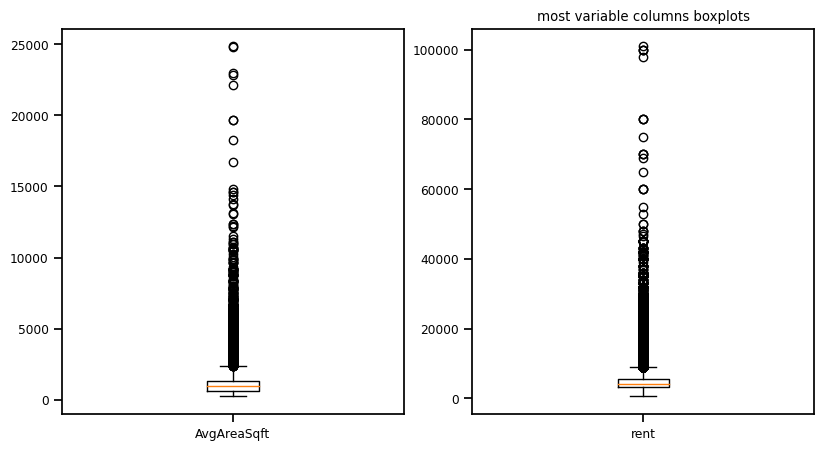

In [39]:
sns.set_context('notebook', font_scale=0.8)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.boxplot(df.AvgAreaSqft, labels = ['AvgAreaSqft'])
plt.subplot(132)
plt.boxplot(df.rent, labels = ['rent'])
plt.title('most variable columns boxplots')

### 1.7 Hadling outliers
#### - defining data range boundaries

In [40]:
avg_area_q1 = np.percentile(df.AvgAreaSqft, 25)
avg_area_q3 = np.percentile(df.AvgAreaSqft, 75)
avg_area_iqr = avg_area_q3 - avg_area_q1

print(avg_area_q1 - (1.5 * avg_area_iqr))
print (avg_area_q3 + (1.5 * avg_area_iqr))

-400.0
2400.0


In [41]:
rent_q1 = np.percentile(df.rent, 25)
rent_q3 = np.percentile(df.rent, 75)
rent_iqr = rent_q3 - rent_q1

print(rent_q1 - (1.5 * rent_iqr))
print(rent_q3 + (1.5 * rent_iqr))

-250.0
8950.0


#### - as lower boundaries calcuated via IQR are negative and the distributions are not normal, trim the outliers using using __[DistFit package](https://pypi.org/project/distfit/)__

In [42]:
dfit = distfit() 

In [43]:
f_area = dfit.fit_transform(df.AvgAreaSqft)
f_area['model']

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 7.95357e-05] [loc=1077.566 scale=625.964]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 8.37352e-05] [loc=250.000 scale=827.566]
[distfit] >INFO> [pareto    ] [0.34 sec] [RSS: 8.37351e-05] [loc=-1099511627526.000 scale=1099511627776.000]
[distfit] >INFO> [dweibull  ] [1.81 sec] [RSS: 7.78977e-05] [loc=996.580 scale=426.635]
[distfit] >INFO> [t         ] [16.1 sec] [RSS: 8.0065e-05] [loc=1103.401 scale=627.678]
[distfit] >INFO> [genextreme] [17.6 sec] [RSS: 8.1864e-05] [loc=352.557 scale=621.649]
[distfit] >INFO> [gamma     ] [4.47 sec] [RSS: 0.000101594] [loc=350.000 scale=1.895]
[distfit] >INFO> [lognorm   ] [6.18 sec] [RSS: 0.000126383] [loc=250.000 scale=3.936]
[distfit] >INFO> [beta      ] [5.49 sec] [RSS: 7.66329e-05] [loc=248.951 scale=5305909023605450.000]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.000100008] [loc=250.000 scale=24596.154]
[distfit] >INFO> [loggamma  ] [3.04 sec]

{'name': 'beta',
 'score': 7.663286822803909e-05,
 'loc': 248.95110196188568,
 'scale': 5305909023605450.0,
 'arg': (2.2753442413522453, 14481250049712.926),
 'params': (2.2753442413522453,
  14481250049712.926,
  248.95110196188568,
  5305909023605450.0),
 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1d3984a9520>,
 'bootstrap_score': 0,
 'bootstrap_pass': None,
 'color': '#e41a1c',
 'CII_min_alpha': 421.58035015713585,
 'CII_max_alpha': 2148.411516378092}

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Beta(loc:248.951102, scale:5305909023605450.000000)


(<Figure size 2000x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'\nbeta(a=2.27534, b=1.44813e+13, loc=248.951, scale=5.30591e+15)'}, xlabel='Values', ylabel='Frequency'>)

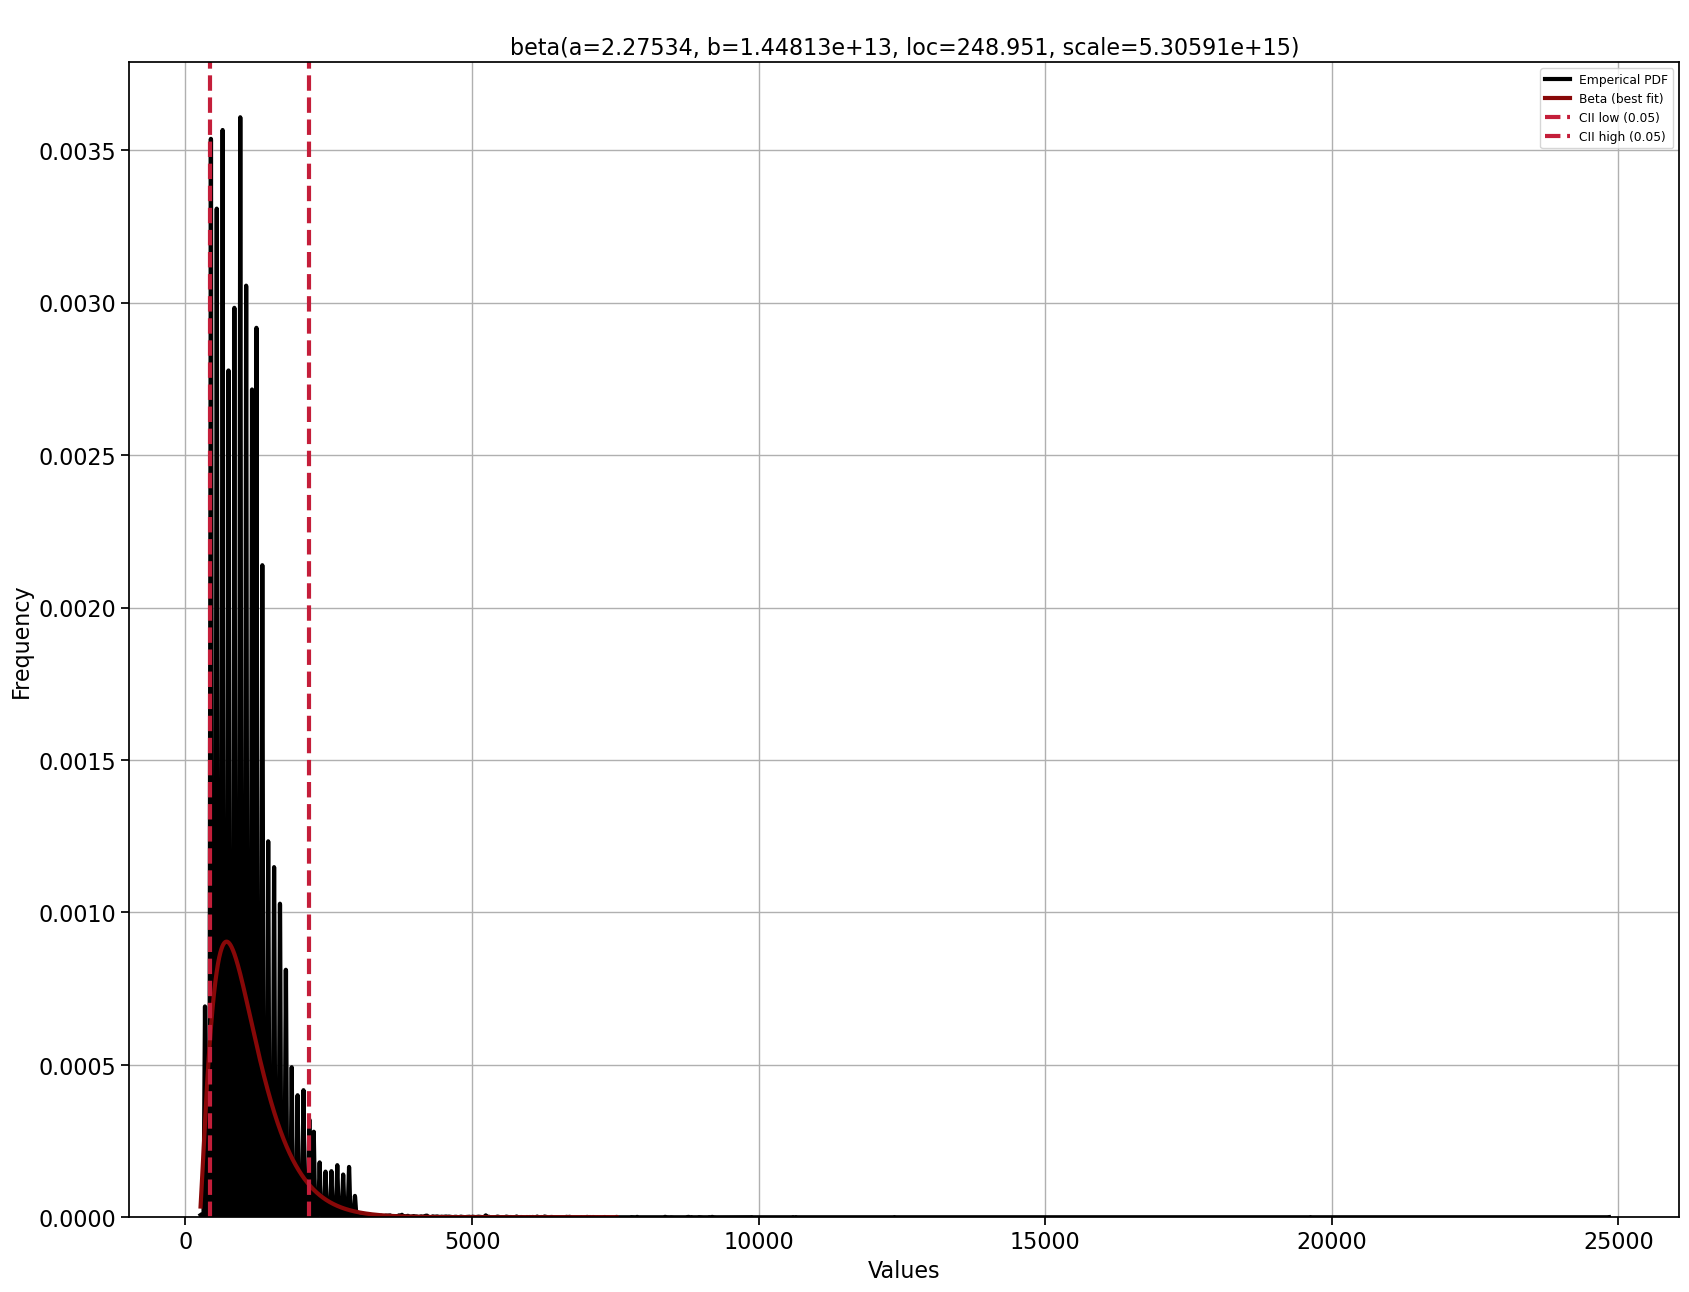

In [44]:
dfit.plot()

In [45]:
AvgAreaSqft_lower_bound = dfit.model['CII_min_alpha']
AvgAreaSqft_upper_bound = dfit.model['CII_max_alpha']

In [46]:
f_rent = dfit.fit_transform(df.rent)
f_rent['model']

[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 1.37863e-06] [loc=4847.414 scale=2954.315]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 1.97007e-06] [loc=566.000 scale=4281.414]
[distfit] >INFO> [pareto    ] [0.32 sec] [RSS: 1.97007e-06] [loc=-274877906378.000 scale=274877906944.000]
[distfit] >INFO> [dweibull  ] [3.87 sec] [RSS: 8.90715e-07] [loc=4000.000 scale=1529.497]
[distfit] >INFO> [t         ] [17.3 sec] [RSS: 8.47495e-07] [loc=4051.061 scale=1189.334]
[distfit] >INFO> [genextreme] [8.92 sec] [RSS: 4.52477e-06] [loc=567.223 scale=7.346]
[distfit] >INFO> [gamma     ] [4.25 sec] [RSS: 2.91383e-06] [loc=1500.000 scale=3.379]
[distfit] >INFO> [lognorm   ] [9.07 sec] [RSS: 4.50833e-06] [loc=566.000 scale=5.001]
[distfit] >INFO> [beta      ] [6.27 sec] [RSS: 8.90983e-07] [loc=565.628 scale=4609402741324144.000]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 2.79566e-06] [loc=566.

{'name': 't',
 'score': 8.474945768789172e-07,
 'loc': 4051.0607517795634,
 'scale': 1189.3336297137141,
 'arg': (1.9801973920042237,),
 'params': (1.9801973920042237, 4051.0607517795634, 1189.3336297137141),
 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1d398113d00>,
 'bootstrap_score': 0,
 'bootstrap_pass': None,
 'color': '#e41a1c',
 'CII_min_alpha': 554.4231282517999,
 'CII_max_alpha': 7547.6983753073255}

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: T(loc:4051.060752, scale:1189.333630)


(<Figure size 2000x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'\nt(df=1.9802, loc=4051.06, scale=1189.33)'}, xlabel='Values', ylabel='Frequency'>)

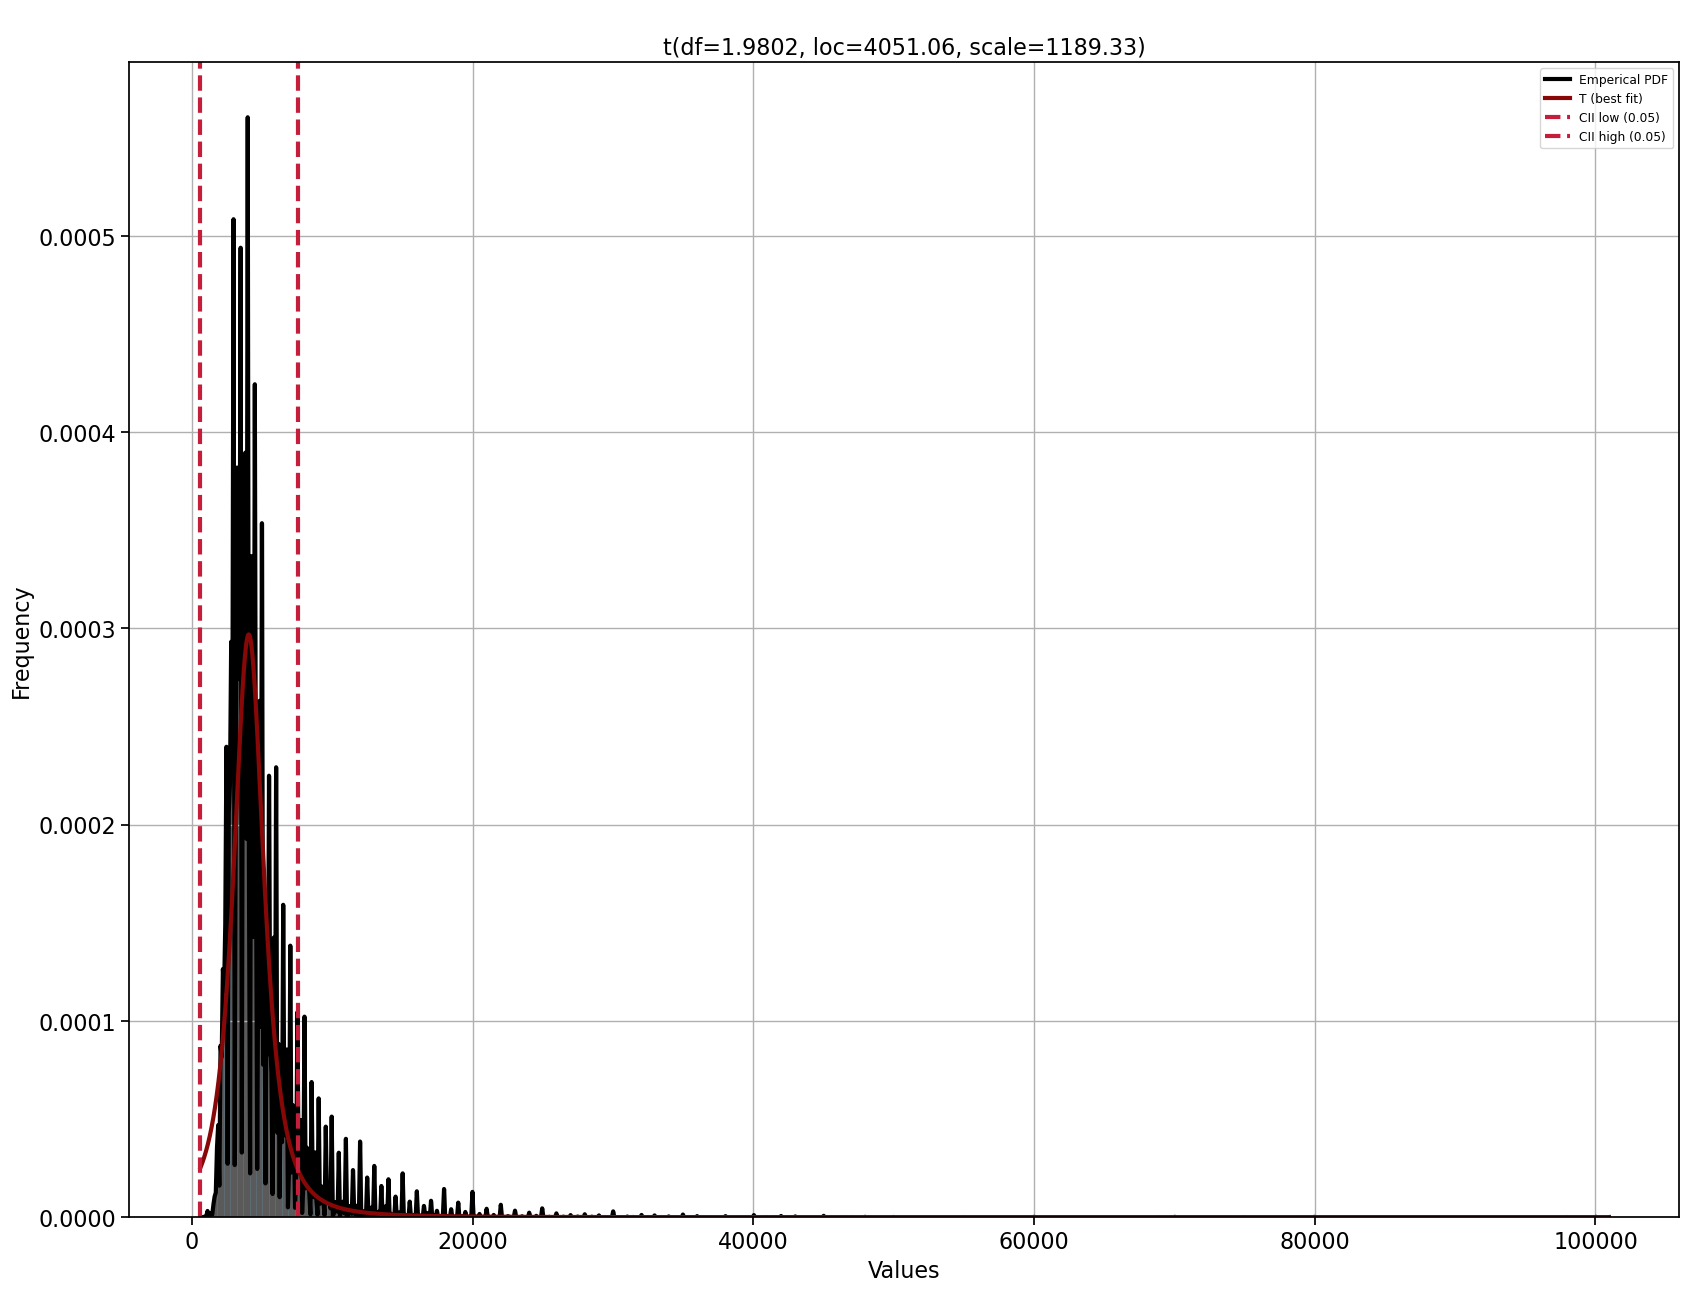

In [47]:
dfit.plot()

In [48]:
rent_lower_bound = dfit.model['CII_min_alpha']
rent_upper_bound = dfit.model['CII_max_alpha']

In [49]:
print('Average area, sqft - lower boundary: ', round(AvgAreaSqft_lower_bound, 3), 'Average area, sqft  - upper boundary: '
      , round(AvgAreaSqft_upper_bound, 3))
print('Rent, SGD - lower boundary: ', round(rent_lower_bound, 3), 'Rent, SGD - upper boundary: ', round(rent_upper_bound, 3))

Average area, sqft - lower boundary:  421.58 Average area, sqft  - upper boundary:  2148.412
Rent, SGD - lower boundary:  554.423 Rent, SGD - upper boundary:  7547.698


#### - considering counts of values out of the bounded range

In [50]:
df[~df['AvgAreaSqft'].between(AvgAreaSqft_lower_bound, AvgAreaSqft_upper_bound, inclusive='both')].describe()

noOfBedRoom           rent   AvgAreaSqft    SGDperSqft
count  11480.000000   11480.000000  11480.000000  11480.000000
mean       2.945296    9735.907578   2171.322591      5.175822
std        1.242090    7186.200445   1484.541473      2.176505
min        1.000000    1200.000000    250.000000      0.980392
25%        1.000000    3800.000000    350.000000      3.555556
50%        3.000000    8717.000000   2350.000000      4.782163
75%        4.000000   13000.000000   2750.000000      6.470588
max        8.000000  101000.000000  24846.153846     15.789474

In [51]:
df[~df['rent'].between(rent_lower_bound, rent_upper_bound, inclusive='both')].describe()

noOfBedRoom           rent   AvgAreaSqft    SGDperSqft
count  16598.000000   16598.000000  16598.000000  16598.000000
mean       3.332751   11225.803772   2133.934019      5.517428
std        0.675322    5026.655415   1081.107232      1.462530
min        1.000000    7550.000000    650.000000      1.368421
25%        3.000000    8300.000000   1550.000000      4.558140
50%        3.000000    9500.000000   1950.000000      5.319149
75%        4.000000   12300.000000   2450.000000      6.285714
max        8.000000  101000.000000  24846.153846     15.789474

#### -  excluding outliers from the dataframe

In [52]:
exol1 = df[df['AvgAreaSqft'].between(AvgAreaSqft_lower_bound, AvgAreaSqft_upper_bound, inclusive='both')]
df_exol = exol1[exol1['rent'].between(rent_lower_bound, rent_upper_bound, inclusive='both')].reset_index(drop=True)

df_exol

leaseDate                         project            street district  \
0      2022-01-01        ELLIOT AT THE EAST COAST       ELLIOT ROAD       15   
1      2022-01-01                   PANDAN VALLEY     PANDAN VALLEY       21   
2      2022-01-01                   PANDAN VALLEY     PANDAN VALLEY       21   
3      2022-01-01                   PANDAN VALLEY     PANDAN VALLEY       21   
4      2022-01-01                       LAKEVILLE  JURONG LAKE LINK       22   
...           ...                             ...               ...      ...   
140983 2023-12-01                      AVA TOWERS          AVA ROAD       12   
140984 2023-12-01                      AVA TOWERS          AVA ROAD       12   
140985 2023-12-01  NON-LANDED HOUSING DEVELOPMENT       MERGUI ROAD       08   
140986 2023-12-01                8 @ MOUNT SOPHIA      MOUNT SOPHIA       09   
140987 2023-12-01                 UPTOWN @ FARRER      PERUMAL ROAD       08   

                  x            y  noOfBedRoom   areaSqft  rent  AvgAreaSqft  \
0       38865.17182  32621.92134            3  1300-1400  3600       1350.0   
1        21855.4646  33439.85679            2  1600-1700  3350       1650.0   
2        21855.4646  33439.85679            3  2000-2100  4400       2050.0   
3        21855.4646  33439.85679            2  1400-1500  2400       1450.0   
4       16060.73955  36356.05166            3   900-1000  3700        950.0   
...             ...          ...          ...        ...   ...          ...   
140983   30059.9759  33837.47233            3  1200-1300  3400       1250.0   
140984   30059.9759  33837.47233            3  1200-1300  4700       1250.0   
140985  30075.77502  33325.38545            2    800-900  4500        850.0   
140986  29415.96417  31487.80728            3  1300-1400  7500       1350.0   
140987  30477.87296  32796.58779            3    600-700  5500        650.0   

        SGDperSqft  
0         2.666667  
1         2.030303  
2         2.146341  
3         1.655172  
4         3.894737  
...            ...  
140983    2.720000  
140984    3.760000  
140985    5.294118  
140986    5.555556  
140987    8.461538  

[140988 rows x 11 columns]

#### - repeating the plotting of the data

Text(0.5, 1.0, 'boxplots of most variable columns excluding outliers')

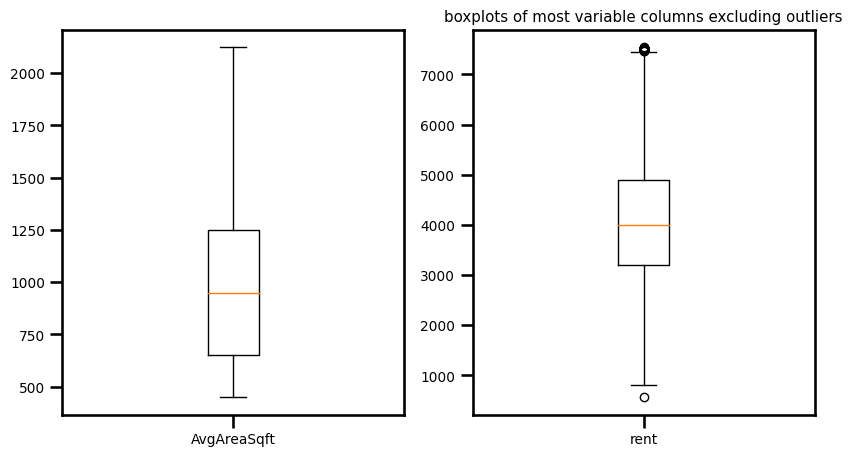

In [53]:
sns.set_context('talk', font_scale=0.6)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.boxplot(df_exol.AvgAreaSqft, labels = ['AvgAreaSqft'])
plt.subplot(132)
plt.boxplot(df_exol.rent, labels = ['rent'])
plt.title('boxplots of most variable columns excluding outliers')

<AxesSubplot:xlabel='rent'>

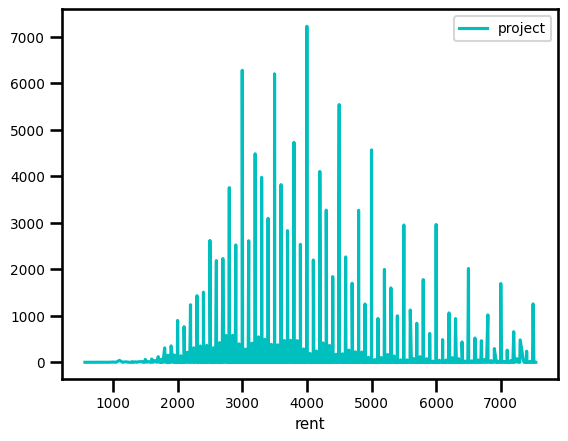

In [54]:
che = df_exol.groupby(['rent']).count().reset_index()
che.plot(x='rent', y='project', c='c')

### 1.8 Complementing the data with additional columns of world global system coordinates using OneMap API Client

#### - making a reference dataframe of coordinates in order to shorten implementation time

In [55]:
xs = df_exol['x'].unique()
ys = df_exol['y'].unique()

In [56]:
ref_coord_df = pd.DataFrame(zip(xs, ys), columns = ['X', 'Y'])
ref_coord_df

X                 Y
0          38865.17182       32621.92134
1           21855.4646       33439.85679
2          16060.73955       36356.05166
3          26515.18941       32328.43973
4          38220.78033       32214.91617
...                ...               ...
2527       34576.58324       40448.41572
2528       36887.72678       33394.62547
2529       33814.95808       32631.18267
2530  30287.5161531412  33060.5875782509
2531       33780.40935       33134.98206

[2532 rows x 2 columns]

#### - adding longitude and latitude for respective SVY21 coordinates with OneMap API Client

In [74]:
@on_exception(expo, RateLimitException, max_tries=21) #exponential back-off decoration
@limits(calls=200, period=60) #decoration setting the limit of calls per minute according to OneMap API info
def wgs84_svy21_coord(row, token): # function converting SVY21 coordinates into WGS84 format
    onemap = OneMap(token) #initiating OpenMapobject for API query
    cr = onemap.converter.convert3414to4326(row['X'], row['Y'])
    row['latitude'] = cr['latitude']
    row['longitude'] = cr['longitude']
    return row

#### - completing the reference dataframe

In [75]:
%%time
ref_coord_df = ref_coord_df.apply(wgs84_svy21_coord, token=access_token, axis=1)

Wall time: 13min 36s


In [76]:
ref_coord_df.head()

X            Y  latitude   longitude
0  38865.17182  32621.92134  1.311294  103.930947
1   21855.4646  33439.85679  1.318692  103.778107
2  16060.73955  36356.05166  1.345063  103.726037
3  26515.18941  32328.43973  1.308641  103.819977
4  38220.78033  32214.91617  1.307613  103.925157

In [78]:
ref_coord_df.to_csv('SG_coord_reference.csv', index=False)

#### - merging the main dataframe with reference one

In [79]:
df_exol = df_exol.merge(ref_coord_df, left_on='x', right_on='X').drop(['X','Y'], axis=1)
df_exol

leaseDate                   project                 street district  \
0      2022-01-01  ELLIOT AT THE EAST COAST            ELLIOT ROAD       15   
1      2022-01-01  ELLIOT AT THE EAST COAST            ELLIOT ROAD       15   
2      2022-01-01  ELLIOT AT THE EAST COAST            ELLIOT ROAD       15   
3      2022-02-01  ELLIOT AT THE EAST COAST            ELLIOT ROAD       15   
4      2022-03-01  ELLIOT AT THE EAST COAST            ELLIOT ROAD       15   
...           ...                       ...                    ...      ...   
140983 2023-12-01                      NOMA        GUILLEMARD ROAD       14   
140984 2023-12-01        MAPLE LEAF ELITE 1           RANGOON ROAD       08   
140985 2023-12-01        MAPLE LEAF ELITE 1           RANGOON ROAD       08   
140986 2023-12-01        MAPLE LEAF ELITE 1           RANGOON ROAD       08   
140987 2023-12-01               CRYSTAL DEW  GEYLANG EAST AVENUE 1       14   

                       x                 y  noOfBedRoom   areaSqft  rent  \
0            38865.17182       32621.92134            3  1300-1400  3600   
1            38865.17182       32621.92134            2   900-1000  3200   
2            38865.17182       32621.92134            2   900-1000  3200   
3            38865.17182       32621.92134            3  1300-1400  4000   
4            38865.17182       32621.92134            3  1300-1400  4500   
...                  ...               ...          ...        ...   ...   
140983       33814.95808       32631.18267            1    600-700  3800   
140984  30287.5161531412  33060.5875782509            1    700-800  3800   
140985  30287.5161531412  33060.5875782509            1    700-800  4150   
140986  30287.5161531412  33060.5875782509            2   900-1000  4800   
140987       33780.40935       33134.98206            3  1400-1500  6500   

        AvgAreaSqft  SGDperSqft  latitude   longitude  
0            1350.0    2.666667  1.311294  103.930947  
1             950.0    3.368421  1.311294  103.930947  
2             950.0    3.368421  1.311294  103.930947  
3            1350.0    2.962963  1.311294  103.930947  
4            1350.0    3.333333  1.311294  103.930947  
...             ...         ...       ...         ...  
140983        650.0    5.846154  1.311379  103.885569  
140984        750.0    5.066667  1.315263  103.853873  
140985        750.0    5.533333  1.315263  103.853873  
140986        950.0    5.052632  1.315263  103.853873  
140987       1450.0    4.482759  1.315935  103.885258  

[140988 rows x 13 columns]

##### Description of the added columns
__latitude__    -   The latitude coordinates of the address of the property in WGS84 format.<br> 
__longitude__   -   The longitude coordinates of the address of the property in WGS84 format. <br>

### 1.9 Complementing the data with additional columns of geometry and neibourhood and region names

In [80]:
geodf = geopandas.GeoDataFrame(data = df_exol[['leaseDate', 'project', 'street', 'district', 'noOfBedRoom'
                                          , 'AvgAreaSqft', 'rent', 'SGDperSqft', 'latitude', 'longitude']]
                               , geometry = geopandas.points_from_xy(df_exol.longitude, df_exol.latitude))
geodf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 140988 entries, 0 to 140987
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   leaseDate    140988 non-null  datetime64[ns]
 1   project      140988 non-null  object        
 2   street       140988 non-null  object        
 3   district     140988 non-null  object        
 4   noOfBedRoom  140988 non-null  int64         
 5   AvgAreaSqft  140988 non-null  float64       
 6   rent         140988 non-null  int64         
 7   SGDperSqft   140988 non-null  float64       
 8   latitude     140988 non-null  float64       
 9   longitude    140988 non-null  float64       
 10  geometry     140988 non-null  geometry      
dtypes: datetime64[ns](1), float64(4), geometry(1), int64(2), object(3)
memory usage: 12.9+ MB


In [81]:
pba_file = open('planning-boundary-area.geojson') #data from official source at https://data.gov.sg/dataset/master-plan-2019-planning-area-boundary-no-sea
pba_df = geopandas.read_file(pba_file)
pba_df.head()

Name               PLN_AREA_N PLN_AREA_C  CA_IND        REGION_N REGION_C  \
0  kml_1              BUKIT MERAH         BM   False  CENTRAL REGION       CR   
1  kml_2            BUKIT PANJANG         BP   False     WEST REGION       WR   
2  kml_3              BUKIT TIMAH         BT   False  CENTRAL REGION       CR   
3  kml_4  CENTRAL WATER CATCHMENT         CC   False    NORTH REGION       NR   
4  kml_5                   CHANGI         CH   False     EAST REGION       ER   

            INC_CRC      FMEL_UPD_D  \
0  5321BA51A092CCC2  20191206144714   
1  6C222E4C54F9F0F7  20191206144714   
2  6CCDADD1F85173E9  20191206144714   
3  9F30125764C74984  20191206144714   
4  6F32A6036888B139  20191206144714   

                                            geometry  
0  POLYGON ((103.81740 1.29433, 103.81787 1.29393...  
1  POLYGON ((103.77445 1.39029, 103.77499 1.38607...  
2  POLYGON ((103.79766 1.34813, 103.79806 1.34779...  
3  POLYGON ((103.80578 1.41436, 103.80594 1.41403...  
4  POLYGON ((103.98693 1.39794, 103.98765 1.39783...

In [82]:
pba_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Name        55 non-null     object  
 1   PLN_AREA_N  55 non-null     object  
 2   PLN_AREA_C  55 non-null     object  
 3   CA_IND      55 non-null     bool    
 4   REGION_N    55 non-null     object  
 5   REGION_C    55 non-null     object  
 6   INC_CRC     55 non-null     object  
 7   FMEL_UPD_D  55 non-null     int64   
 8   geometry    55 non-null     geometry
dtypes: bool(1), geometry(1), int64(1), object(6)
memory usage: 3.6+ KB


In [83]:
def area_name(geopoint): #applying area name based on geometry    
    for i in pba_df.index:
        if  geopoint.within(pba_df['geometry'][i]):        
            return pba_df['PLN_AREA_N'][i]
        else:
            pass

In [84]:
geodf['PlanAreaName'] = geodf['geometry'].map(area_name)
geodf.head()

leaseDate                   project       street district  noOfBedRoom  \
0 2022-01-01  ELLIOT AT THE EAST COAST  ELLIOT ROAD       15            3   
1 2022-01-01  ELLIOT AT THE EAST COAST  ELLIOT ROAD       15            2   
2 2022-01-01  ELLIOT AT THE EAST COAST  ELLIOT ROAD       15            2   
3 2022-02-01  ELLIOT AT THE EAST COAST  ELLIOT ROAD       15            3   
4 2022-03-01  ELLIOT AT THE EAST COAST  ELLIOT ROAD       15            3   

   AvgAreaSqft  rent  SGDperSqft  latitude   longitude  \
0       1350.0  3600    2.666667  1.311294  103.930947   
1        950.0  3200    3.368421  1.311294  103.930947   
2        950.0  3200    3.368421  1.311294  103.930947   
3       1350.0  4000    2.962963  1.311294  103.930947   
4       1350.0  4500    3.333333  1.311294  103.930947   

                    geometry PlanAreaName  
0  POINT (103.93095 1.31129)        BEDOK  
1  POINT (103.93095 1.31129)        BEDOK  
2  POINT (103.93095 1.31129)        BEDOK  
3  POINT (103.93095 1.31129)        BEDOK  
4  POINT (103.93095 1.31129)        BEDOK

In [85]:
#adding Singapore region names
geodf = geodf.merge(pba_df[['PLN_AREA_N', 'REGION_N']], left_on = 'PlanAreaName', right_on = 'PLN_AREA_N').drop(['PLN_AREA_N'], axis=1)

In [96]:
geodf.latitude = geodf.latitude.astype('object')
geodf.longitude = geodf.longitude.astype('object')

### Final dataframe prepared for analysis:

In [92]:
geodf

leaseDate                         project                 street  \
0      2022-01-01        ELLIOT AT THE EAST COAST            ELLIOT ROAD   
1      2022-01-01                 SEVEN HOLT ROAD              HOLT ROAD   
2      2022-01-01                      PARC EMILY       MOUNT EMILY ROAD   
3      2022-01-01               YEWTEE RESIDENCES  CHOA CHU KANG NORTH 6   
4      2022-01-01                  THE EQUATORIAL           STEVENS ROAD   
...           ...                             ...                    ...   
140983 2023-12-01                      TREE HOUSE        CHESTNUT AVENUE   
140984 2023-12-01  NON-LANDED HOUSING DEVELOPMENT      LORONG 22 GEYLANG   
140985 2023-12-01                      TREE HOUSE        CHESTNUT AVENUE   
140986 2023-12-01                         LE WOOD         HINDHEDE DRIVE   
140987 2023-12-01                      THE BEACON        CANTONMENT ROAD   

       district  noOfBedRoom  AvgAreaSqft  rent  SGDperSqft  latitude  \
0            15            3       1350.0  3600    2.666667  1.311294   
1            10            3       1850.0  5100    2.756757  1.293634   
2            09            2        950.0  4100    4.315789  1.303569   
3            23            3       1150.0  3400    2.956522  1.396894   
4            10            4       2050.0  6900    3.365854  1.320228   
...         ...          ...          ...   ...         ...       ...   
140983       23            2        750.0  4100    5.466667  1.370402   
140984       14            2       1150.0  4500    3.913043  1.311420   
140985       23            3       1250.0  5000    4.000000  1.370402   
140986       21            3       1250.0  4400    3.520000  1.347262   
140987       02            3       1450.0  6600    4.551724  1.275944   

         longitude                   geometry   PlanAreaName        REGION_N  
0       103.930947  POINT (103.93095 1.31129)          BEDOK     EAST REGION  
1       103.825824  POINT (103.82582 1.29363)        TANGLIN  CENTRAL REGION  
2       103.849195  POINT (103.84919 1.30357)         ROCHOR  CENTRAL REGION  
3       103.746804  POINT (103.74680 1.39689)  CHOA CHU KANG     WEST REGION  
4       103.824762  POINT (103.82476 1.32023)        TANGLIN  CENTRAL REGION  
...            ...                        ...            ...             ...  
140983  103.777125  POINT (103.77713 1.37040)  BUKIT PANJANG     WEST REGION  
140984  103.882568  POINT (103.88257 1.31142)        GEYLANG  CENTRAL REGION  
140985  103.777125  POINT (103.77713 1.37040)  BUKIT PANJANG     WEST REGION  
140986  103.775790  POINT (103.77579 1.34726)  BUKIT PANJANG     WEST REGION  
140987  103.840402  POINT (103.84040 1.27594)    BUKIT MERAH  CENTRAL REGION  

[140988 rows x 13 columns]

In [97]:
geodf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140988 entries, 0 to 140987
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   leaseDate     140988 non-null  datetime64[ns]
 1   project       140988 non-null  object        
 2   street        140988 non-null  object        
 3   district      140988 non-null  object        
 4   noOfBedRoom   140988 non-null  int64         
 5   AvgAreaSqft   140988 non-null  float64       
 6   rent          140988 non-null  int64         
 7   SGDperSqft    140988 non-null  float64       
 8   latitude      140988 non-null  object        
 9   longitude     140988 non-null  object        
 10  geometry      140988 non-null  geometry      
 11  PlanAreaName  140988 non-null  object        
 12  REGION_N      140988 non-null  object        
dtypes: datetime64[ns](1), float64(2), geometry(1), int64(2), object(7)
memory usage: 14.0+ MB


## 2. Data Analysis: EDA and features visualization

### 2.1 Reviewing main statistics and correlation

In [98]:
geodf.describe()

noOfBedRoom    AvgAreaSqft           rent     SGDperSqft
count  140988.000000  140988.000000  140988.000000  140988.000000
mean        2.089674     950.252980    4125.458606       4.724969
std         0.832923     362.389937    1278.095568       1.591491
min         1.000000     450.000000     566.000000       0.485714
25%         1.000000     650.000000    3200.000000       3.529412
50%         2.000000     950.000000    4000.000000       4.521739
75%         3.000000    1250.000000    4900.000000       5.777778
max         6.000000    2124.976910    7542.000000      15.926667

In [211]:
#mean, median and mode by regions
mr_df = geodf[['REGION_N','noOfBedRoom', 'AvgAreaSqft', 'rent', 'SGDperSqft']].groupby('REGION_N').agg([pd.Series.mean, pd.Series.median, pd.Series.mode]).round(1)
mr_df

noOfBedRoom             AvgAreaSqft                    rent  \
                         mean median mode        mean  median    mode    mean   
REGION_N                                                                        
CENTRAL REGION            2.0    2.0    2       947.8   950.0   450.0  4439.9   
EAST REGION               2.2    2.0    2       966.4   950.0   950.0  3608.1   
NORTH REGION              2.2    2.0    2       910.2   950.0  1150.0  3304.3   
NORTH-EAST REGION         2.1    2.0    2       886.7   850.0   450.0  3527.6   
WEST REGION               2.3    2.0    3      1006.7  1050.0  1250.0  3921.3   

                                SGDperSqft              
                   median  mode       mean median mode  
REGION_N                                                
CENTRAL REGION     4300.0  4000        5.1    4.9  4.0  
EAST REGION        3500.0  3000        4.0    3.8  4.0  
NORTH REGION       3200.0  3000        3.9    3.7  4.0  
NORTH-EAST REGION  3400.0  3000        4.3    4.2  4.0  
WEST REGION        3800.0  4000        4.2    4.0  4.0

<AxesSubplot:>

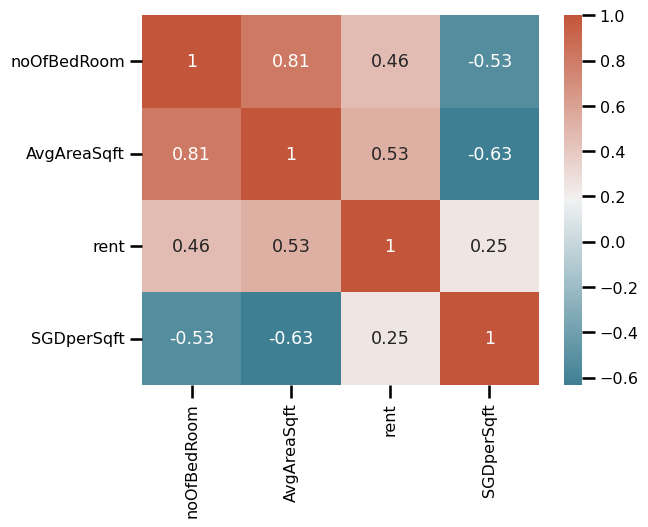

In [100]:
corr = geodf.corr() # plot the heatmap
sns.set_context('talk', font_scale=0.7)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

#### the correlation map presents strong positive correlation between average area and number of bedrooms as well as rent, while the correlation between unit price and average area as weel as number of bedroom is pretty strong negative.

### 2.2 Exploping top districts and projects by number of lease contracts

In [206]:
districts_df = geodf[['district', 'project', 'PlanAreaName']].groupby('district').agg(
    lease_count = ('project', 'size'), neigborhood = ('PlanAreaName', 'unique')).sort_values(
    by='lease_count', ascending=False).reset_index()
districts_df['percentage'] = round(100 * (districts_df['lease_count'] / districts_df['lease_count'].sum()),1)
districts_df = districts_df.iloc[:,[0,1,3,2]]
districts_df

district  lease_count  percentage  \
0        15        12149         8.6   
1        09        11790         8.4   
2        19        11187         7.9   
3        14        10188         7.2   
4        10         9681         6.9   
5        05         7877         5.6   
6        16         7232         5.1   
7        03         7037         5.0   
8        23         6146         4.4   
9        18         5961         4.2   
10       11         5735         4.1   
11       12         5636         4.0   
12       21         4819         3.4   
13       22         4377         3.1   
14       01         3915         2.8   
15       20         3811         2.7   
16       13         3783         2.7   
17       08         3629         2.6   
18       02         3115         2.2   
19       17         2592         1.8   
20       27         2506         1.8   
21       04         2213         1.6   
22       07         2149         1.5   
23       28         1688         1.2   
24       25          894         0.6   
25       26          732         0.5   
26       06          146         0.1   

                                          neigborhood  
0            [BEDOK, KALLANG, MARINE PARADE, GEYLANG]  
1   [ROCHOR, SINGAPORE RIVER, MUSEUM, ORCHARD, NOV...  
2   [HOUGANG, SENGKANG, PUNGGOL, TOA PAYOH, SERANG...  
3                 [GEYLANG, BEDOK, KALLANG, TAMPINES]  
4   [TANGLIN, BUKIT TIMAH, NEWTON, ORCHARD, RIVER ...  
5                              [CLEMENTI, QUEENSTOWN]  
6                                   [BEDOK, TAMPINES]  
7   [BUKIT MERAH, SINGAPORE RIVER, QUEENSTOWN, TAN...  
8   [CHOA CHU KANG, BUKIT BATOK, BUKIT PANJANG, BU...  
9                   [TAMPINES, PASIR RIS, PAYA LEBAR]  
10                   [BUKIT TIMAH, NOVENA, TOA PAYOH]  
11              [KALLANG, TOA PAYOH, NOVENA, HOUGANG]  
12  [BUKIT TIMAH, BUKIT BATOK, CLEMENTI, BUKIT PAN...  
13                         [JURONG EAST, JURONG WEST]  
14           [OUTRAM, DOWNTOWN CORE, SINGAPORE RIVER]  
15         [ANG MO KIO, TOA PAYOH, BISHAN, SERANGOON]  
16                    [TOA PAYOH, GEYLANG, SERANGOON]  
17                         [KALLANG, ROCHOR, HOUGANG]  
18               [OUTRAM, DOWNTOWN CORE, BUKIT MERAH]  
19                                        [PASIR RIS]  
20                        [SEMBAWANG, MANDAI, YISHUN]  
21                    [SOUTHERN ISLANDS, BUKIT MERAH]  
22                   [DOWNTOWN CORE, KALLANG, ROCHOR]  
23         [HOUGANG, SENGKANG, SERANGOON, ANG MO KIO]  
24                                        [WOODLANDS]  
25                               [ANG MO KIO, YISHUN]  
26                                    [DOWNTOWN CORE]

In [210]:
proj_df = geodf[['project', 'district', 'leaseDate', 'rent', 'SGDperSqft']].groupby('project').agg(
    lease_count = ('leaseDate','size'), average_rent = ('rent', 'mean'), avg_rent_per_sqft = (
        'SGDperSqft', 'mean'), districts = ('district', 'unique')).sort_values(
    by='lease_count', ascending=False).reset_index()
proj_df['percentage'] = 100 * (proj_df['lease_count'] / proj_df['lease_count'].sum())
proj_df = proj_df.iloc[:,[0,1,5,2,3,4]].round(2)
proj_df.head(15)

project  lease_count  percentage  average_rent  \
0   NON-LANDED HOUSING DEVELOPMENT         3207        2.27       3533.52   
1            THE SAIL @ MARINA BAY         1016        0.72       5118.67   
2                         D'LEEDON          741        0.53       5072.09   
3           CITY SQUARE RESIDENCES          705        0.50       4518.13   
4                        J GATEWAY          701        0.50       4250.21   
5                             ICON          685        0.49       4640.21   
6              STIRLING RESIDENCES          680        0.48       4749.60   
7            MARINA ONE RESIDENCES          674        0.48       5404.92   
8                        PARC ESTA          631        0.45       4784.14   
9                        WATERTOWN          630        0.45       3326.77   
10             COMMONWEALTH TOWERS          618        0.44       4096.27   
11                   MELVILLE PARK          610        0.43       3443.37   
12                SIMS URBAN OASIS          610        0.43       3529.90   
13                   BAYSHORE PARK          590        0.42       3463.58   
14                    PARC RIVIERA          590        0.42       3670.59   

    avg_rent_per_sqft                                          districts  
0                3.49  [01, 10, 08, 15, 09, 14, 11, 23, 05, 13, 12, 0...  
1                6.65                                               [01]  
2                5.26                                               [10]  
3                4.85                                               [08]  
4                6.51                                               [22]  
5                6.55                                               [02]  
6                7.46                                               [03]  
7                6.77                                               [01]  
8                7.44                                               [14]  
9                4.85                                               [19]  
10               7.16                                               [03]  
11               3.23                                               [18]  
12               5.81                                               [14]  
13               3.46                                               [16]  
14               5.37                                               [05]

#### - checking which projects has rented properties in several regions

In [103]:
proj_reg_df = geodf[['project', 'REGION_N', 'leaseDate']].groupby(['project', 'REGION_N']).count().sort_values(
                by='REGION_N', ascending=False).reset_index()

proj_reg_df.loc[
    proj_reg_df.duplicated(subset=['project'], keep=False)
].sort_values(by=['project','leaseDate'], ascending=False)

project           REGION_N  leaseDate
1827  NON-LANDED HOUSING DEVELOPMENT     CENTRAL REGION       2746
270   NON-LANDED HOUSING DEVELOPMENT  NORTH-EAST REGION        221
549   NON-LANDED HOUSING DEVELOPMENT        EAST REGION        190
336   NON-LANDED HOUSING DEVELOPMENT       NORTH REGION         30
8     NON-LANDED HOUSING DEVELOPMENT        WEST REGION         20

### 2.3 Geomapping
#### - preparing the geodataframe and additional data for mapping:
##### * obraining the data on private schools from OneMap

In [104]:
onemap = OneMap(access_token) #initiating OpenMapobject for API query

ti = onemap.themes.getAllThemesInfo()

In [105]:
pd.DataFrame(ti['Theme_Names'])

THEMENAME                QUERYNAME  \
0            After Death Facilities     afterdeathfacilities   
1                     Kindergartens            kindergartens   
2                   Community Clubs           communityclubs   
3    Private Education Institutions         cpe_pei_premises   
4              Constituency Offices      constituencyoffices   
..                              ...                      ...   
159              Healthier Eateries          healthierdining   
160                 Family Services                   family   
161               Vaccination_ JTVC               votg_jtvcs   
162                Vaccination_PHPC                votg_phpc   
163         Vaccination_Polyclinics  vaccination_polyclinics   

                     ICON EXPIRY_DATE PUBLISHED_DATE  
0           coffina20.jpg  31/12/2028     01/01/2012  
1              school.gif  31/12/2026     01/01/2012  
2                  PA.jpg  30/12/2022     31/12/2011  
3                pink.jpg  30/04/2023     01/01/2012  
4                  PA.jpg  31/12/2027     01/01/2012  
..                    ...         ...            ...  
159   HealthierDining.PNG  30/04/2025     02/04/2015  
160  onemap-fc-family.png  31/07/2026     01/01/2012  
161        MOH Logo 2.png  14/01/2025     15/01/2024  
162        MOH Logo 2.png  01/02/2029     01/02/2024  
163        MOH Logo 2.png  27/01/2029     26/01/2024  

[164 rows x 5 columns]

In [106]:
pei = onemap.themes.retrieveTheme('cpe_pei_premises', extents=None)
pei_df = pd.DataFrame(pei['SrchResults'][1:])
pei_df.head()

NAME                     DESCRIPTION  \
0  MIDDLETON INTERNATIONAL SCHOOL  Private Education Institutions   
1          IMPART LEARNING CENTRE  Private Education Institutions   
2  MIRROR D INTERNATIONAL COLLEGE  Private Education Institutions   
3                     MMI ACADEMY  Private Education Institutions   
4                 NANYANG ACADEMY  Private Education Institutions   

  ADDRESSBLOCKHOUSENUMBER ADDRESSPOSTALCODE       ADDRESSSTREETNAME  \
0                       2            528889      TAMPINES STREET 92   
1                      51            079904              ANSON ROAD   
2                       5            050005            BANDA STREET   
3                      72            058702       SOUTH BRIDGE ROAD   
4                     170            588179  Upper Bukit Timah Road   

                          HYPERLINK   Type                             LatLng  \
0      http://www.middleton.edu.sg/  Point  1.34266452430936,103.942461175191   
1  http://impartlearningcentre.com/  Point     1.2745078714975,103.8457102267   
2              www.mdisingapore.com  Point  1.28119736227423,103.843437320481   
3       http://www.mmi-academy.com/  Point  1.28704936839415,103.847878026443   
4            https://www.nya.edu.sg  Point  1.34332078891647,103.775854163937   

  ICON_NAME          ADDRESSBUILDINGNAME ADDRESSUNITNUMBER  
0  pink.jpg                          NaN               NaN  
1  pink.jpg                 ANSON CENTRE             07-53  
2  pink.jpg           KRETA AYER HEIGHTS             02-68  
3  pink.jpg                 MMI BUILDING               NaN  
4  pink.jpg  Bukit Timah Shopping Centre            #15-04

In [169]:
pei_df

NAME  \
0                MIDDLETON INTERNATIONAL SCHOOL   
1                        IMPART LEARNING CENTRE   
2                MIRROR D INTERNATIONAL COLLEGE   
3                                   MMI ACADEMY   
4                               NANYANG ACADEMY   
..                                          ...   
279              NEW CAMBRIDGE EDUCATION CENTRE   
280   NEWCASTLE RESEARCH & INNOVATION INSTITUTE   
281    INTERNATIONAL COLLEGE OF HOLISTIC HEALTH   
282  INTERNATIONAL COMMUNITY SCHOOL (SINGAPORE)   
283   MELBOURNE SPECIALIST INTERNATIONAL SCHOOL   

                        DESCRIPTION ADDRESSBLOCKHOUSENUMBER ADDRESSPOSTALCODE  \
0    Private Education Institutions                       2            528889   
1    Private Education Institutions                      51            079904   
2    Private Education Institutions                       5            050005   
3    Private Education Institutions                      72            058702   
4    Private Education Institutions                     170            588179   
..                              ...                     ...               ...   
279  Private Education Institutions                   188-4            436990   
280  Private Education Institutions                      80            609607   
281  Private Education Institutions                    716A            389629   
282  Private Education Institutions                     27A            128575   
283  Private Education Institutions                     75C            248853   

          ADDRESSSTREETNAME                         HYPERLINK   Type  \
0        TAMPINES STREET 92      http://www.middleton.edu.sg/  Point   
1                ANSON ROAD  http://impartlearningcentre.com/  Point   
2              BANDA STREET              www.mdisingapore.com  Point   
3         SOUTH BRIDGE ROAD       http://www.mmi-academy.com/  Point   
4    Upper Bukit Timah Road            https://www.nya.edu.sg  Point   
..                      ...                               ...    ...   
279     Tanjong Katong Road           www.newcambridge.com.sg  Point   
280   Jurong East Street 21  www.ncl.ac.uk/singapore/newriis/  Point   
281            GEYLANG ROAD       http://www.1939academy.com/  Point   
282            Jubilee Road                    www.ics.edu.sg  Point   
283             LOEWEN ROAD                   www.msis.edu.sg  Point   

                                LatLng ICON_NAME          ADDRESSBUILDINGNAME  \
0    1.34266452430936,103.942461175191  pink.jpg                          NaN   
1       1.2745078714975,103.8457102267  pink.jpg                 ANSON CENTRE   
2    1.28119736227423,103.843437320481  pink.jpg           KRETA AYER HEIGHTS   
3    1.28704936839415,103.847878026443  pink.jpg                 MMI BUILDING   
4    1.34332078891647,103.775854163937  pink.jpg  Bukit Timah Shopping Centre   
..                                 ...       ...                          ...   
279  1.30917207441238,103.894349787251  pink.jpg                          NaN   
280  1.33590457478914,103.744636423955  pink.jpg         Devan Nair Institute   
281  1.31475209101512,103.891451311398  pink.jpg                          NaN   
282  1.30705154479452,103.766293476241  pink.jpg                          NaN   
283  1.30167215610773,103.812399642784  pink.jpg                          NaN   

    ADDRESSUNITNUMBER  
0                 NaN  
1               07-53  
2               02-68  
3                 NaN  
4              #15-04  
..                ...  
279               NaN  
280             05-04  
281               NaN  
282               NaN  
283               NaN  

[284 rows x 11 columns]

In [171]:
filters = ['SCHOOL', 'INSTITUTE', 'ACADEMY', 'COLLEGE']
pei_df = pei_df[pei_df.apply(lambda x: x.str.contains('|'.join(filters), case=False)).any(axis=1)]

In [172]:
pei_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 0 to 283
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   NAME                     249 non-null    object
 1   DESCRIPTION              249 non-null    object
 2   ADDRESSBLOCKHOUSENUMBER  249 non-null    object
 3   ADDRESSPOSTALCODE        249 non-null    object
 4   ADDRESSSTREETNAME        249 non-null    object
 5   HYPERLINK                234 non-null    object
 6   Type                     249 non-null    object
 7   LatLng                   249 non-null    object
 8   ICON_NAME                249 non-null    object
 9   ADDRESSBUILDINGNAME      156 non-null    object
 10  ADDRESSUNITNUMBER        174 non-null    object
dtypes: object(11)
memory usage: 23.3+ KB


##### *preparing the dataframe grouped by planning areas

In [108]:
geodf_comb = geodf[['PlanAreaName', 'project', 'rent', 'SGDperSqft']].groupby('PlanAreaName').agg(
    {'project': 'count', 'rent': 'mean', 'SGDperSqft': 'mean'}).rename(columns={'project': 'lease count'}).reset_index()

In [109]:
geodf_comb

PlanAreaName  lease count         rent  SGDperSqft
0         ANG MO KIO         1479  3767.323867    3.747948
1              BEDOK        13159  3737.689642    4.158610
2             BISHAN         2686  4110.101266    4.583410
3        BUKIT BATOK         4104  3574.167154    3.815107
4        BUKIT MERAH         6888  4872.716609    5.481566
5      BUKIT PANJANG         2248  3681.678381    3.860172
6        BUKIT TIMAH         7429  4584.969983    4.433727
7      CHOA CHU KANG         1049  3351.095329    3.304130
8           CLEMENTI         4464  4277.359543    4.697480
9      DOWNTOWN CORE         6533  4895.523190    6.652469
10           GEYLANG         9943  3615.410842    4.853095
11           HOUGANG         4531  3469.486427    4.257318
12       JURONG EAST         1629  4045.880909    4.512222
13       JURONG WEST         2748  4200.895560    4.545557
14           KALLANG         7083  4041.563038    4.692065
15            MANDAI           88  3586.795455    2.836163
16     MARINE PARADE         4612  4588.085863    4.390010
17            MUSEUM          935  4894.029947    6.257731
18            NEWTON         2633  5060.451956    5.156866
19            NOVENA         7945  4186.726117    4.709273
20           ORCHARD          713  5518.314165    6.479184
21            OUTRAM          671  4219.289121    5.038659
22         PASIR RIS         5419  3386.351541    3.835619
23        PAYA LEBAR            5  3380.000000    2.177340
24           PUNGGOL         1553  3511.799099    4.415367
25        QUEENSTOWN         6461  4379.850178    5.433434
26      RIVER VALLEY         4564  5069.046889    5.689168
27            ROCHOR         2707  4114.738825    5.257624
28         SEMBAWANG          365  3270.586301    3.448391
29          SENGKANG         2437  3360.313500    4.403592
30         SERANGOON         4609  3601.550662    4.450994
31   SINGAPORE RIVER         2290  5151.594760    5.348017
32  SOUTHERN ISLANDS          170  6575.911765    4.560178
33          TAMPINES         3781  3475.488760    3.882531
34           TANGLIN         5393  4815.288151    4.764340
35         TOA PAYOH         4616  3983.677643    5.119797
36         WOODLANDS          894  3121.744966    3.972819
37            YISHUN         2154  3374.185701    4.019281

#### - creating a map and adding a rent-visualization layer and data markers

In [173]:
m = fs.Map(location=[1.290270, 103.851959])

In [174]:
choro_test = fs.Choropleth(geo_data = 'planning-boundary-area.geojson',
                            data = geodf_comb,
                            columns = ['PlanAreaName','rent'],
                            key_on = 'feature.properties.PLN_AREA_N', #pathway to locate each town and its geometry in the geojson file
                            fill_color = 'RdYlGn_r', # colour of choropleth
                            nan_fill_color = 'White', # color for empty data
                            fill_opacity = 0.4, #density of colour
                            line_opacity = 0.3,
                            legend_name = 'AVERAGE RENT COST',
                            line_color = 'grey',
                            nan_fill_opacity = 0.3, highlight=True).add_to(m)
fs.TileLayer('cartodbpositron').add_to(m)

In [112]:
choro_test.geojson.data.keys()

dict_keys(['type', 'name', 'crs', 'features'])

In [110]:
choro_test.geojson.data['features'][0]

{'type': 'Feature',
 'properties': {'Name': 'kml_1',
  'PLN_AREA_N': 'BUKIT MERAH',
  'PLN_AREA_C': 'BM',
  'CA_IND': False,
  'REGION_N': 'CENTRAL REGION',
  'REGION_C': 'CR',
  'INC_CRC': '5321BA51A092CCC2',
  'FMEL_UPD_D': 20191206144714},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[103.817404504805, 1.29433192068794],
    [103.81786774928, 1.29392922800993],
    [103.818414502703, 1.29393123899475],
    [103.818416498367, 1.29393124624148],
    [103.818550237481, 1.29393170011605],
    [103.818552553924, 1.29393170736455],
    [103.818667621319, 1.2939320806349],
    [103.818865940503, 1.29393275101078],
    [103.819102674874, 1.29381092266042],
    [103.821616893093, 1.29357188755592],
    [103.821690495622, 1.29352838342666],
    [103.821775431498, 1.29347817890817],
    [103.821777444239, 1.2934769851558],
    [103.821825661067, 1.29344838755159],
    [103.821828176994, 1.29344689626547],
    [103.8227464099, 1.29290354975449],
    [103.823162738865, 1.29265716631009],


In [175]:
geodf_comb_index = geodf_comb.set_index('PlanAreaName')
#using a for loop to add rental costs into the geojson file, allowing the mapping to work
for i in choro_test.geojson.data['features']:
        if i['properties']['PLN_AREA_N'] not in list(geodf_comb['PlanAreaName']):  
            i['properties']['Average_rent'] = None
            i['properties']['lease_count'] = None
        else:
            i['properties']['Average_rent'] = round(geodf_comb_index.loc[i['properties']['PLN_AREA_N'], 'rent'], 1)
            i['properties']['lease_count'] = str(geodf_comb_index.loc[i['properties']['PLN_AREA_N'], 'lease count'])

fs.GeoJsonTooltip(fields=['PLN_AREA_N', 'Average_rent', 'lease_count']
                  , aliases=['Area Name: ', 'Average rent, SGD:', 'leases in 2022-2023:']).add_to(choro_test.geojson)

In [176]:
# Adding markers of private schools
for cords, name, web in zip(pei_df['LatLng'], pei_df['NAME'], pei_df['HYPERLINK']):
    fs.Marker(location=[cords.split(',')[0], cords.split(',')[1]],
              popup=f'Name:<br>{name}<br>'
                    f'Web site:<br>{web}<br>'                        
              ).add_to(m)

In [177]:
m

### 2.4 Plotting the data
#### - density charts of rent values for regions

Text(0.5, 1.0, 'Rent Ridgeline Plot by region')

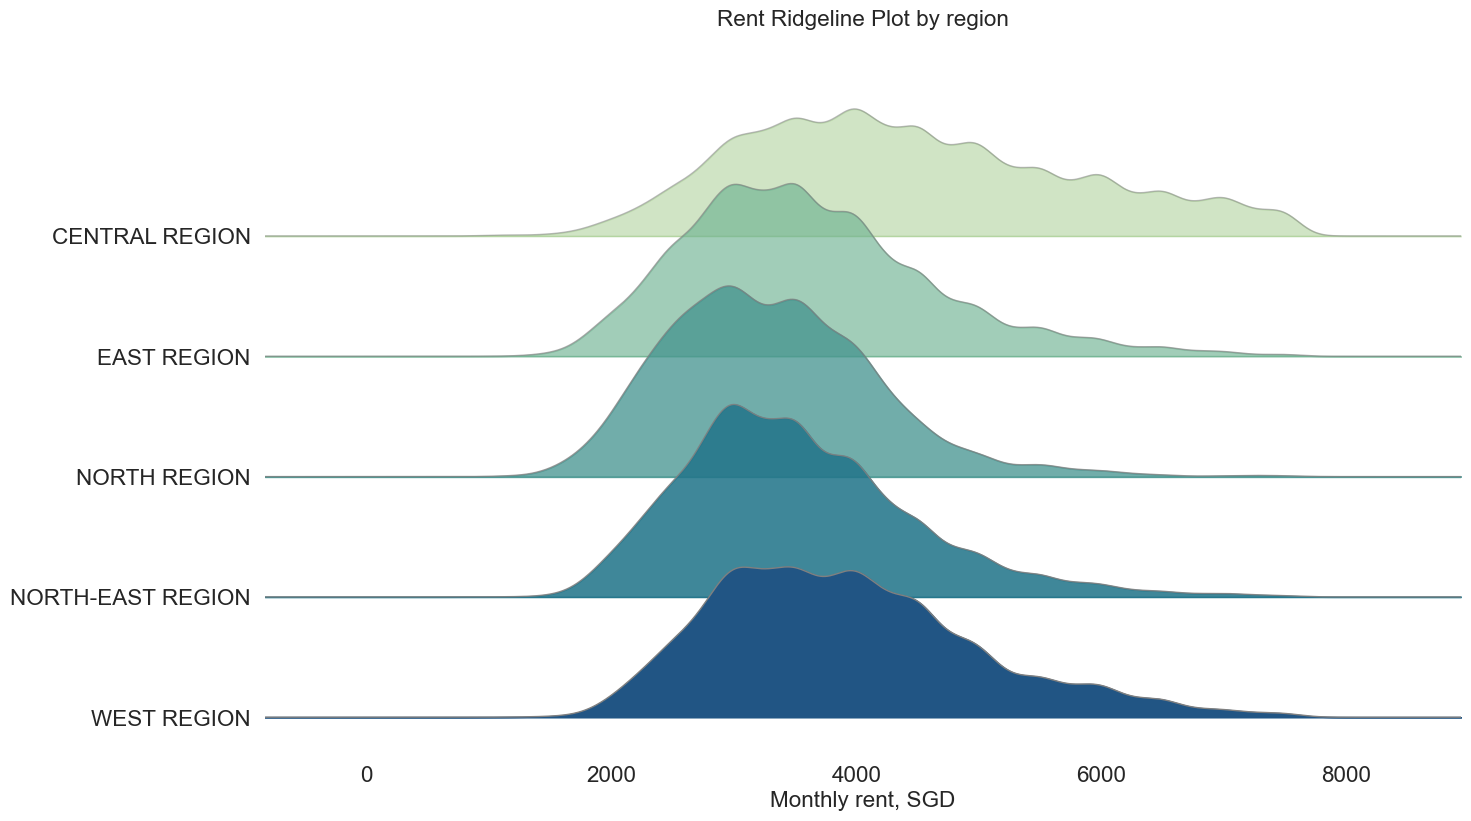

In [185]:
sns.set_context('talk', font_scale=0.9)
joyplot(geodf, by='REGION_N', column='rent', colormap=sns.color_palette('crest', n_colors=5, as_cmap=True), figsize=(15,8)
        , linewidth=1, linecolor='gray', fade=True)
plt.xlabel('Monthly rent, SGD');
plt.title('Rent Ridgeline Plot by region')

#### - rental dynamics with line plots for regions

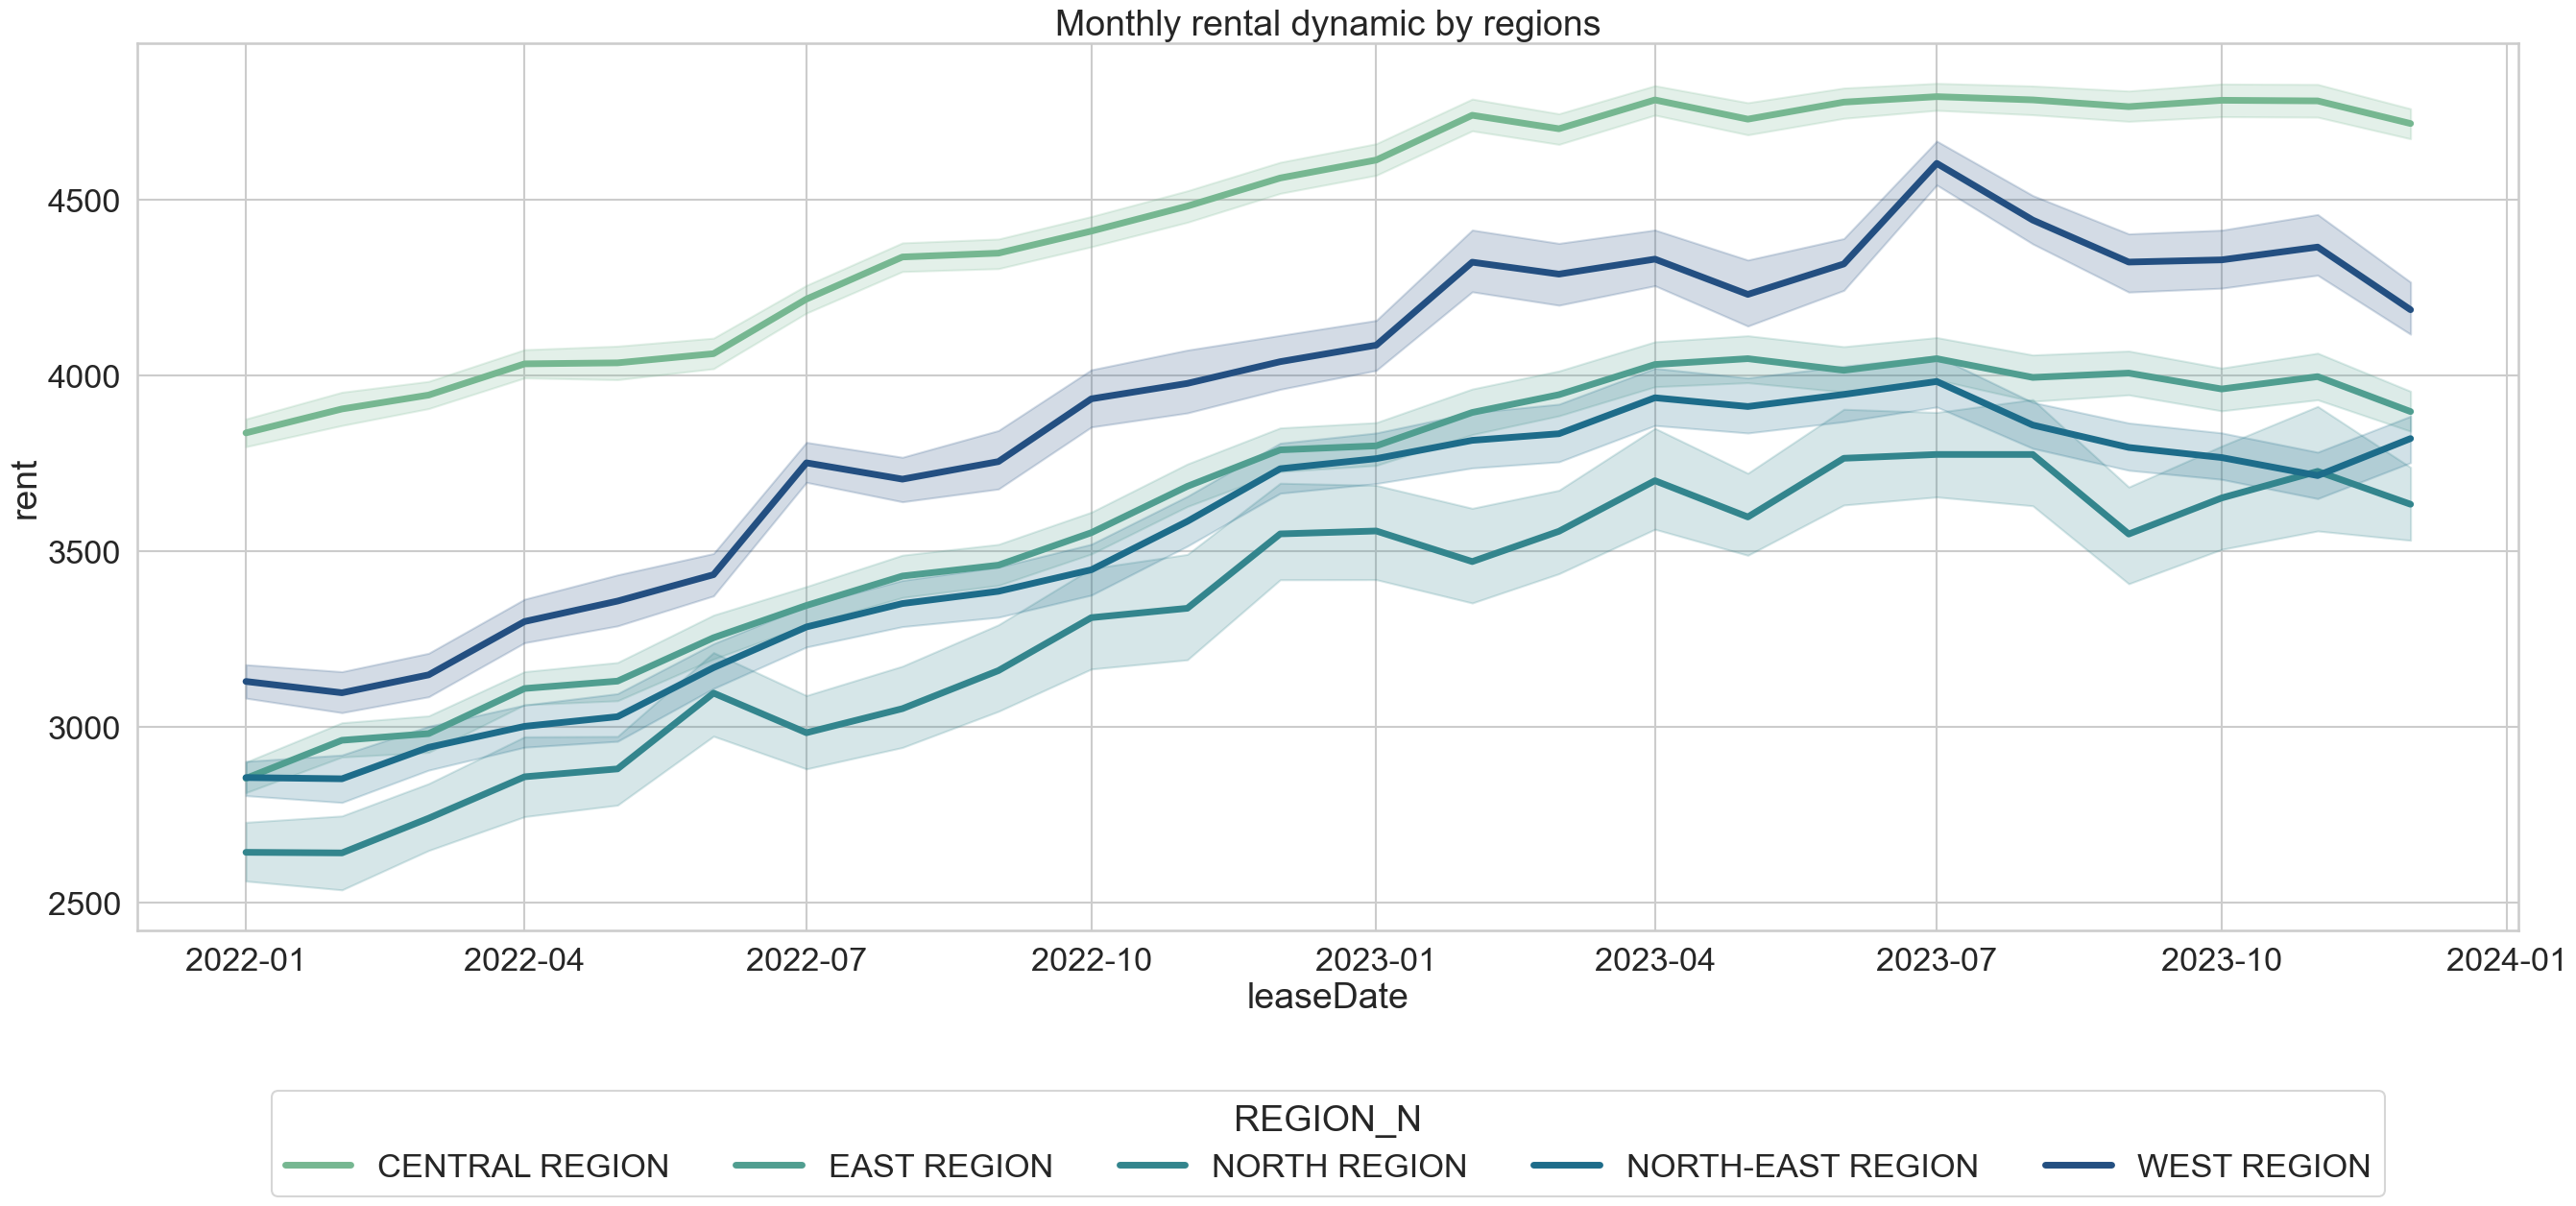

In [187]:
hue_order = sorted(set(geodf['REGION_N']))

plt.figure(figsize=(32,12))
plt.title('Monthly rental dynamic by regions')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 5})
sns.set_style(style='whitegrid')
fig = sns.lineplot(data=geodf, x='leaseDate', y='rent', hue='REGION_N', hue_order=hue_order, palette = 'crest')
sns.move_legend(fig, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=5, borderaxespad=0)

#### - number of properties leased in different Singapore areas

In [ ]:
cdf = geodf[['REGION_N', 'PlanAreaName', 'project']].groupby(['REGION_N', 'PlanAreaName']).count().reset_index().sort_values(by=['REGION_N', 'project'], ascending=True)

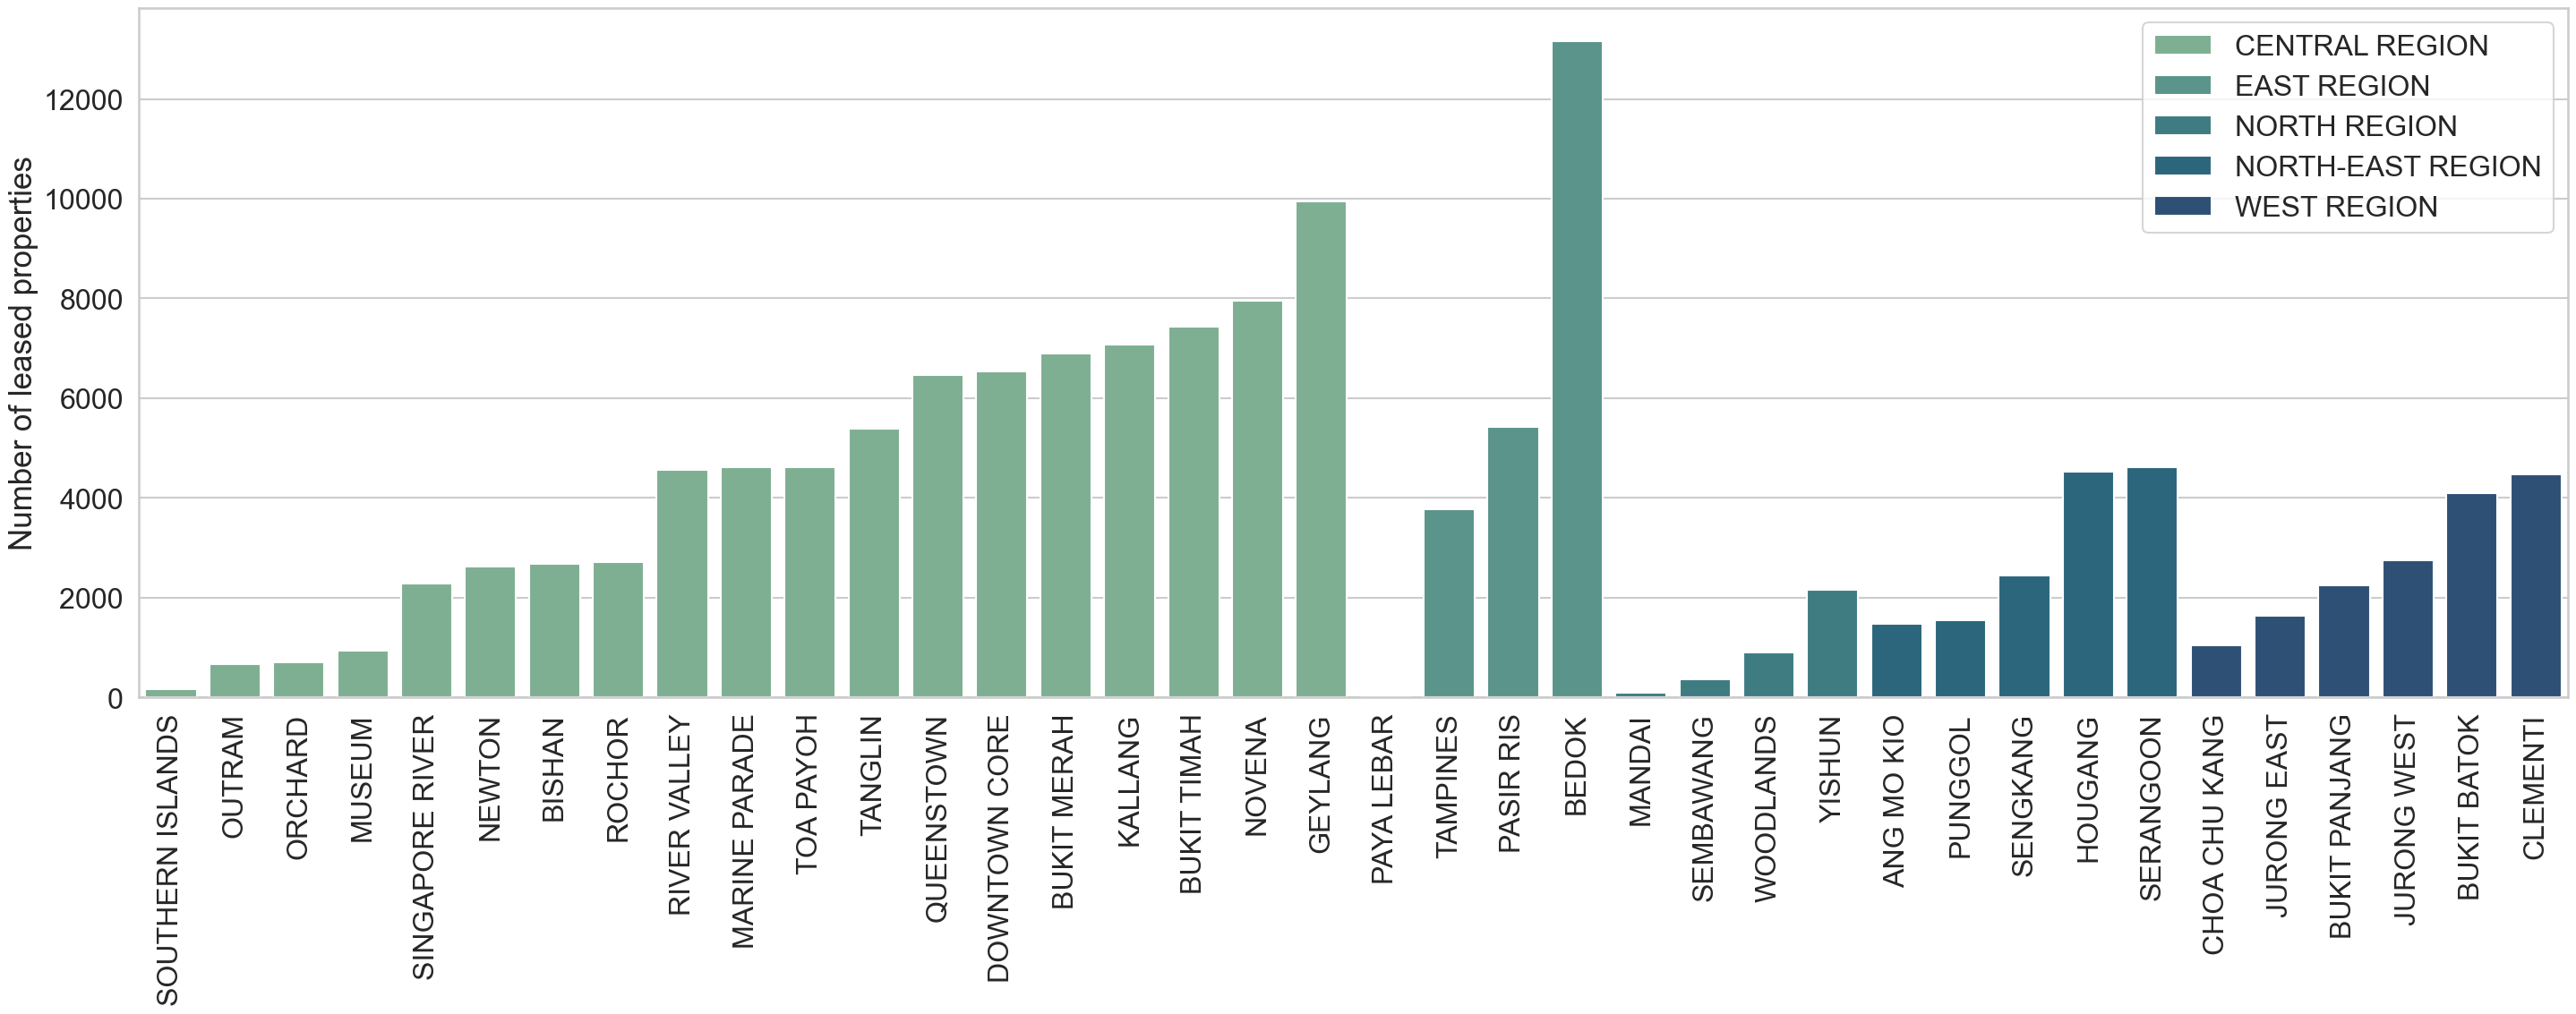

In [188]:
plt.figure(figsize=(35, 10))
sns.set_context('talk', font_scale=1.4)
sns.barplot(data=cdf, x='PlanAreaName', y='project', hue='REGION_N', palette='crest', dodge=False)
plt.xticks(rotation=90)
plt.ylabel('Number of leased properties')
plt.xlabel(None)
plt.legend(loc='upper right')

#### - quantity of leased properties by number of bedrooms

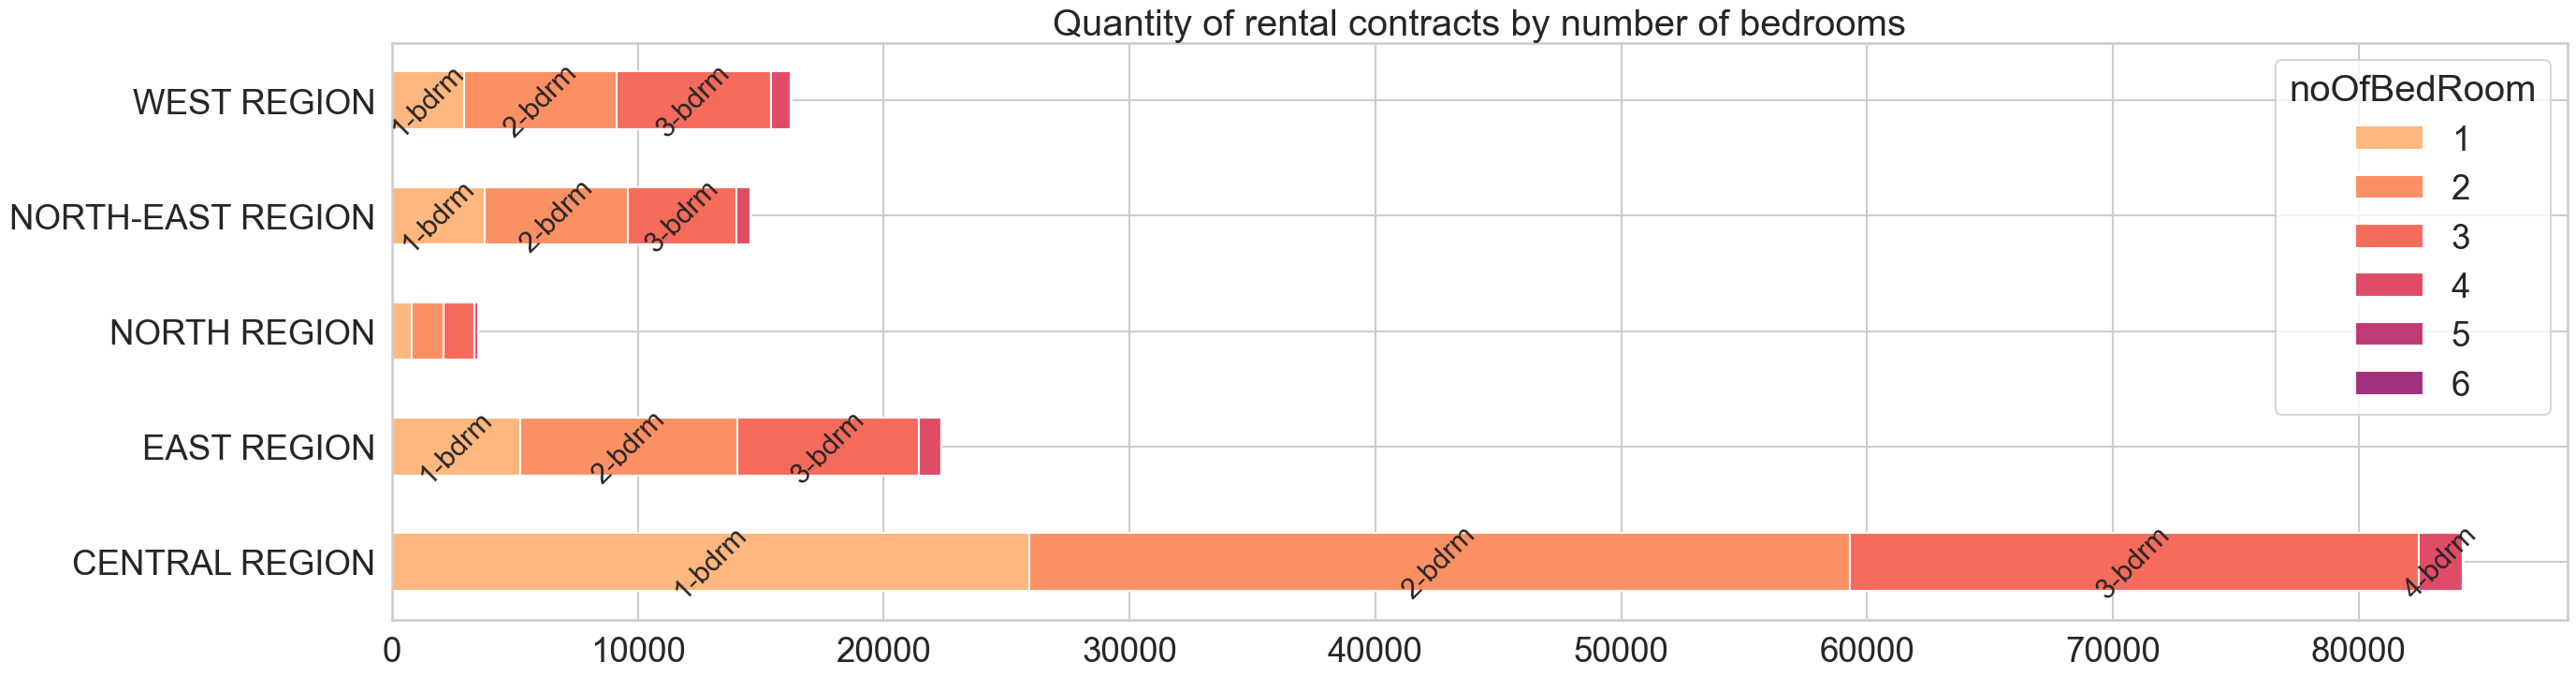

In [189]:
agg_df1 = geodf.pivot_table(index='REGION_N', columns='noOfBedRoom'
                             , values='rent', aggfunc='count')

cpallette = sns.color_palette('magma_r', as_cmap=True)
br_cmp = ListedColormap(cpallette(np.linspace(0.15, 0.55, 85)))

sns.set_style(style='whitegrid')
sns.set_context('talk', font_scale=1.6)
plt.rcParams['figure.figsize'] = [30, 8]
ax1 = agg_df1.plot(kind='barh', colormap=br_cmp, stacked=True)
plt.title('Quantity of rental contracts by number of bedrooms')
plt.xticks(rotation=0)
plt.xlabel(None)
plt.ylabel(None)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10000))

handles1, legend_labels1 = ax1.get_legend_handles_labels()

for c1, l1 in zip(ax1.containers, legend_labels1):
    labels1 = [f'{l1}-bdrm' if (w1 := v1.get_width()) > 1700 else '' for v1 in c1]
    ax1.bar_label(c1, labels=labels1, rotation=45, fontsize=22, label_type='center')

#### - average quarter rent by number of bedrooms

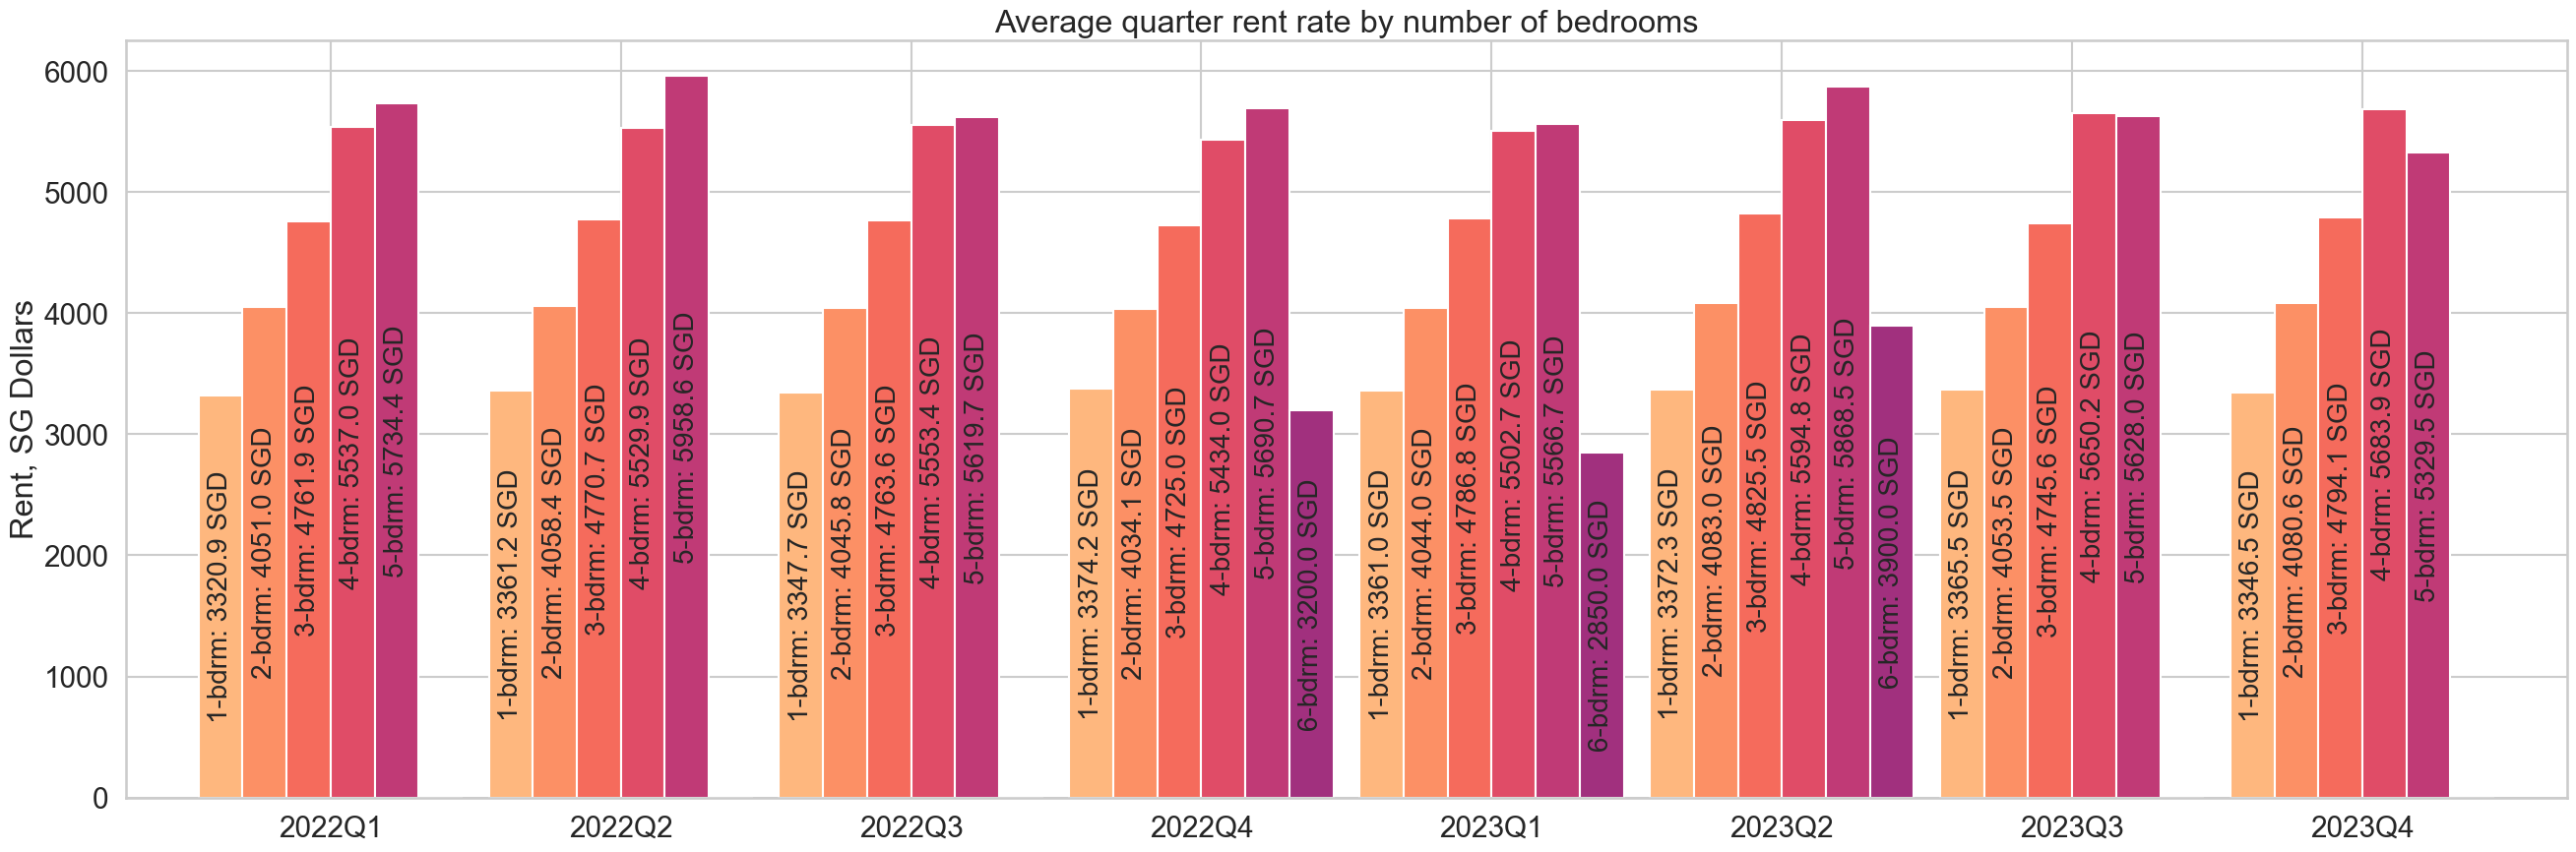

In [183]:
agg_df = geodf.pivot_table(index=pd.to_datetime(df_exol['leaseDate'], format='%Y/%m/%d').dt.to_period('Q')
                           , columns='noOfBedRoom', values='rent', aggfunc=np.nanmean)

sns.set_context('talk', font_scale=1.3)
plt.rcParams['figure.figsize'] = [32, 10]
ax = agg_df.plot(kind='bar', width=0.91, colormap=br_cmp, stacked=False, legend=False)
plt.title('Average quarter rent rate by number of bedrooms')
plt.xticks(rotation=0)
plt.xlabel(None)
plt.ylabel('Rent, SG Dollars')

handles, legend_labels = ax.get_legend_handles_labels()

for c, l in zip(ax.containers, legend_labels):
    labels = [f'{l}-bdrm: {round(w, 1)} SGD' if (w := v.get_height()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, rotation=90, fontsize=20, label_type='center')

#### - scattering of the data depending on property size

Text(0, 0.5, 'Rent, Sg Dollars')

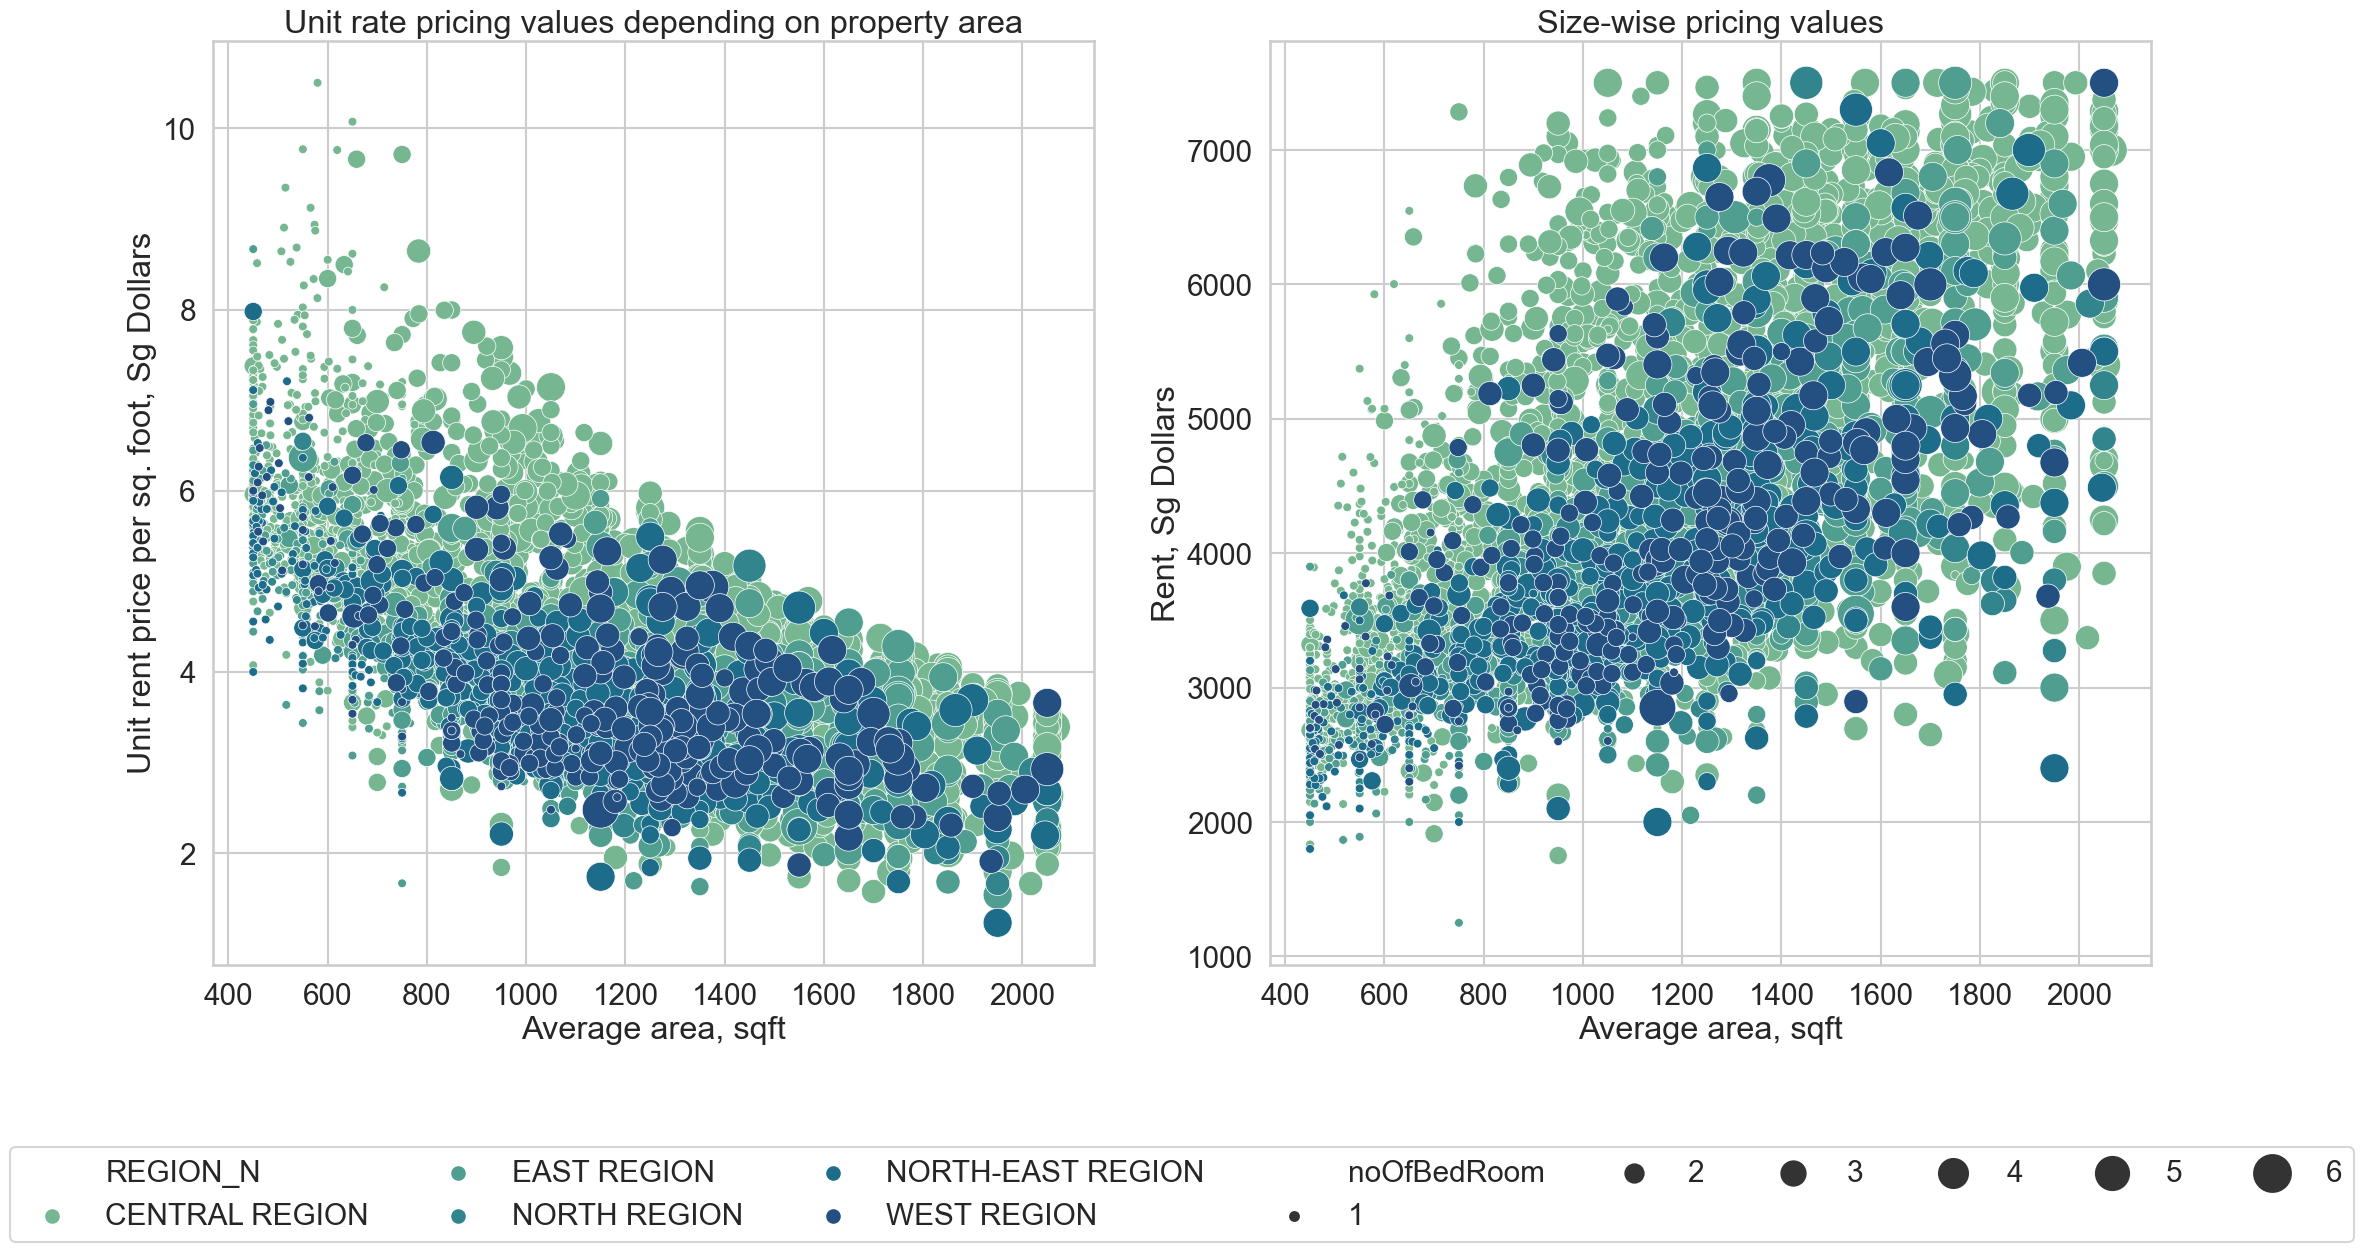

In [190]:
sns.set_context('talk', font_scale=1.3)
sns.set_style(style='whitegrid')
plt.figure(figsize=(25,12))
plt.subplot(121)
plt.title('Unit rate pricing values depending on property area')
sns.scatterplot(x='AvgAreaSqft',
                y='SGDperSqft',
                size='noOfBedRoom',
                sizes=(40, 700),                
                hue='REGION_N',
                palette='crest',
                legend=False,
                data=geodf.groupby(['REGION_N', 'project', 'noOfBedRoom']).mean().reset_index())
plt.xlabel('Average area, sqft')
plt.ylabel('Unit rent price per sq. foot, Sg Dollars')
plt.subplot(122)
plt.title('Size-wise pricing values')
sns.scatterplot(x='AvgAreaSqft', 
                y='rent',
                size='noOfBedRoom',
                sizes=(40, 700),                
                hue='REGION_N',
                palette='crest',                
                data = geodf.groupby(['REGION_N', 'project', 'noOfBedRoom']).mean().reset_index())
# Put the legend out of the figure
plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.3), ncol=9, borderaxespad=0)
plt.xlabel('Average area, sqft')
plt.ticklabel_format(style='plain')
plt.ylabel('Rent, Sg Dollars')

#### - unit rent rate distributions categorized by number of rooms and regions

<AxesSubplot:title={'center':'Distributions of unit rent price per sq. foot'}, xlabel='noOfBedRoom', ylabel='SGDperSqft'>

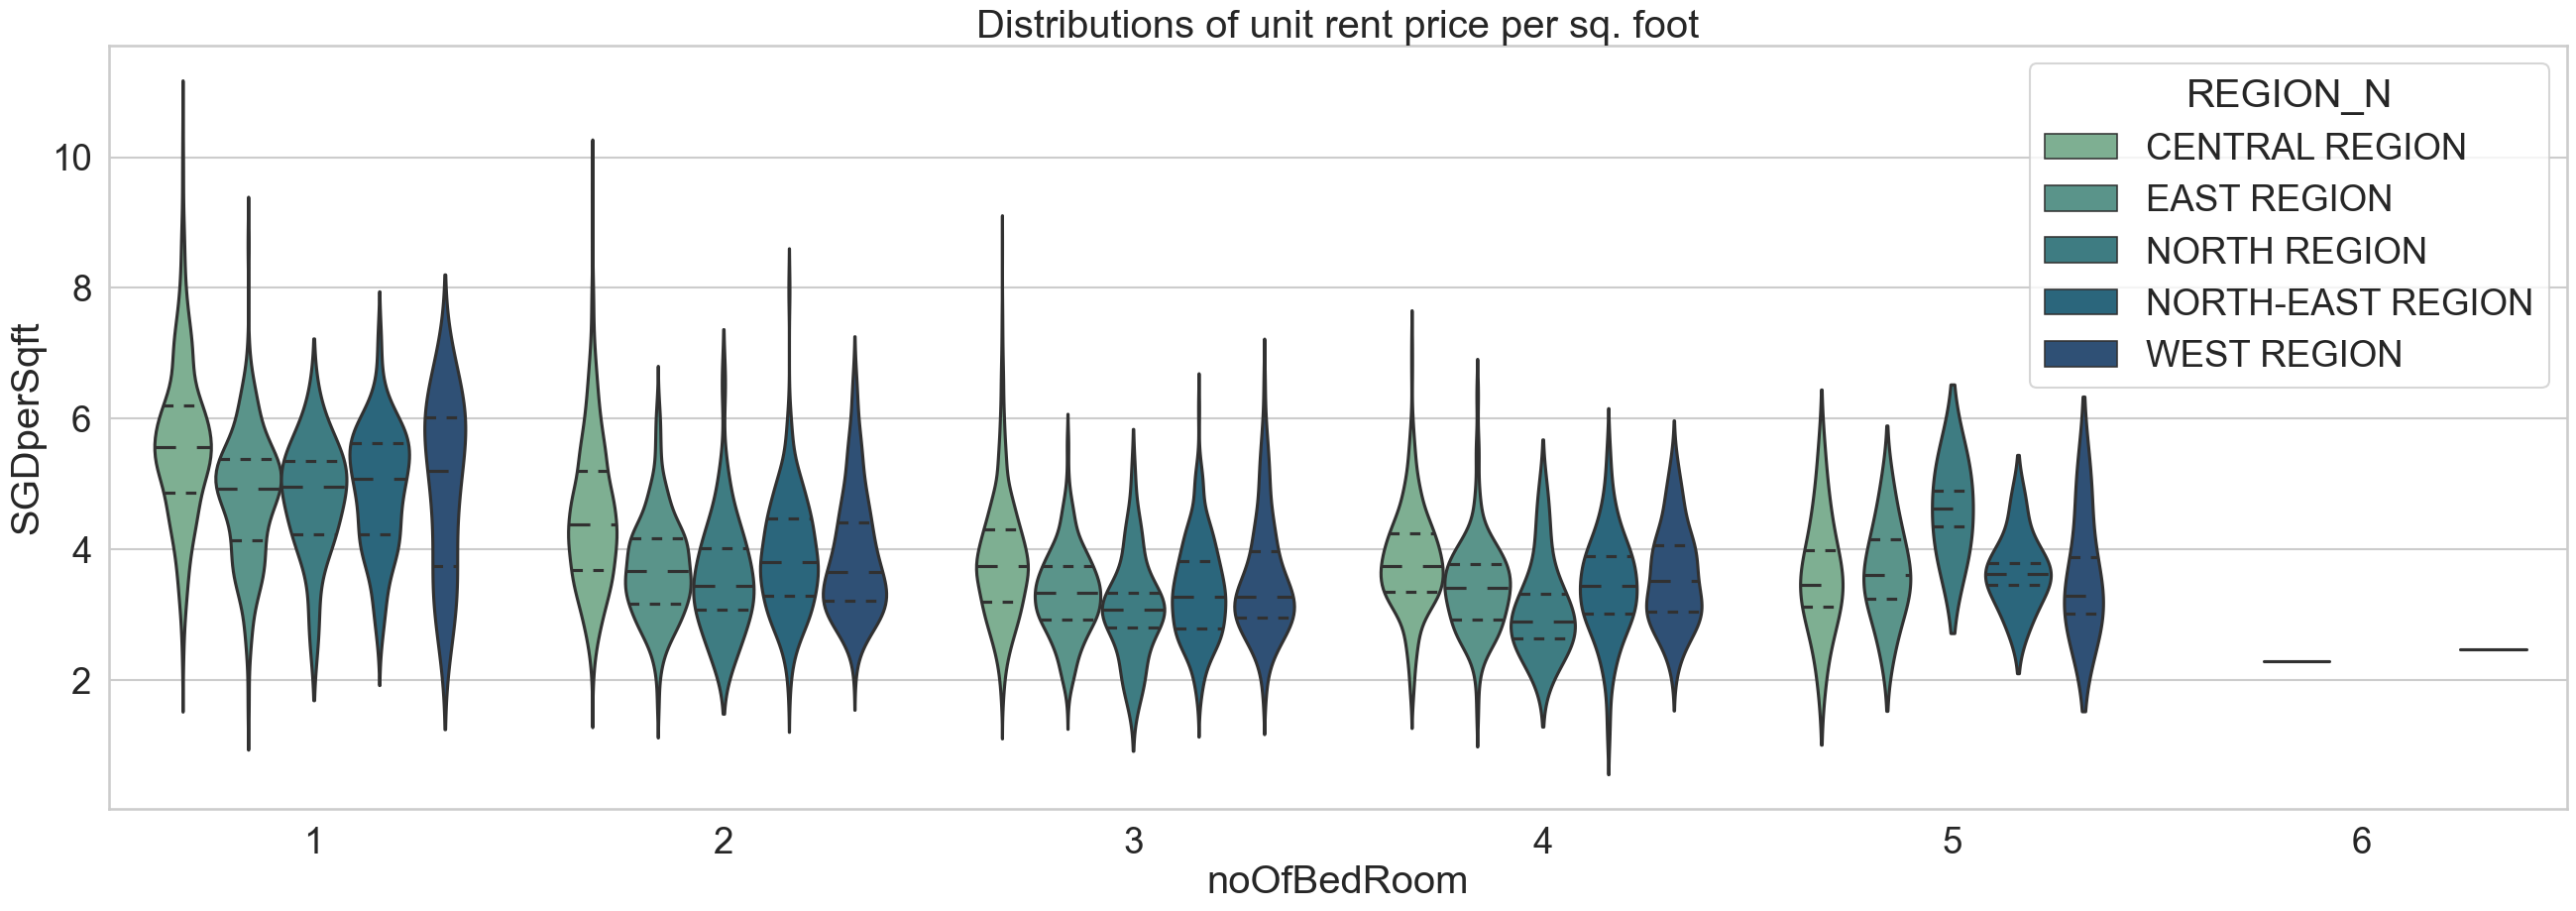

In [184]:
sns.set_context('talk', font_scale=1.6)

plt.title('Distributions of unit rent price per sq. foot')
sns.violinplot(data=geodf.groupby(['REGION_N', 'project', 'noOfBedRoom']).mean().reset_index()
               , y='SGDperSqft', x='noOfBedRoom', hue='REGION_N', palette = 'crest', inner='quart')

## 3. Statistic hypothesis
#### - sampling the data on 2-bedroom properties in the East and North-East regions

In [155]:
e2_rent_sample = geodf[(geodf['REGION_N'] == 'EAST REGION') & (df_exol['noOfBedRoom'] == 2)]['rent'].sample(n=5500)
ne2_rent_sample = geodf[(geodf['REGION_N'] == 'NORTH-EAST REGION') & (df_exol['noOfBedRoom'] == 2)]['rent'].sample(n=5500)

In [156]:
# comparing variances and sizes of the samples
print('2-bedroom rent variance for East: ', round(np.var(e2_rent_sample, ddof=1), 1))
print('Size of East rent sample: ', e2_rent_sample.size)
print('2-bedroom rent variance for North-East: ', round(np.var(ne2_rent_sample, ddof=1), 2))
print('Size of North-East sample: ', ne2_rent_sample.size)
print('The variance ratio:', np.var(e2_rent_sample) / np.var(ne2_rent_sample))

2-bedroom rent variance for East:  994441.4
Size of East rent sample:  5500
2-bedroom rent variance for North-East:  883672.64
Size of North-East sample:  5500
The variance ratio: 1.1253504271652661


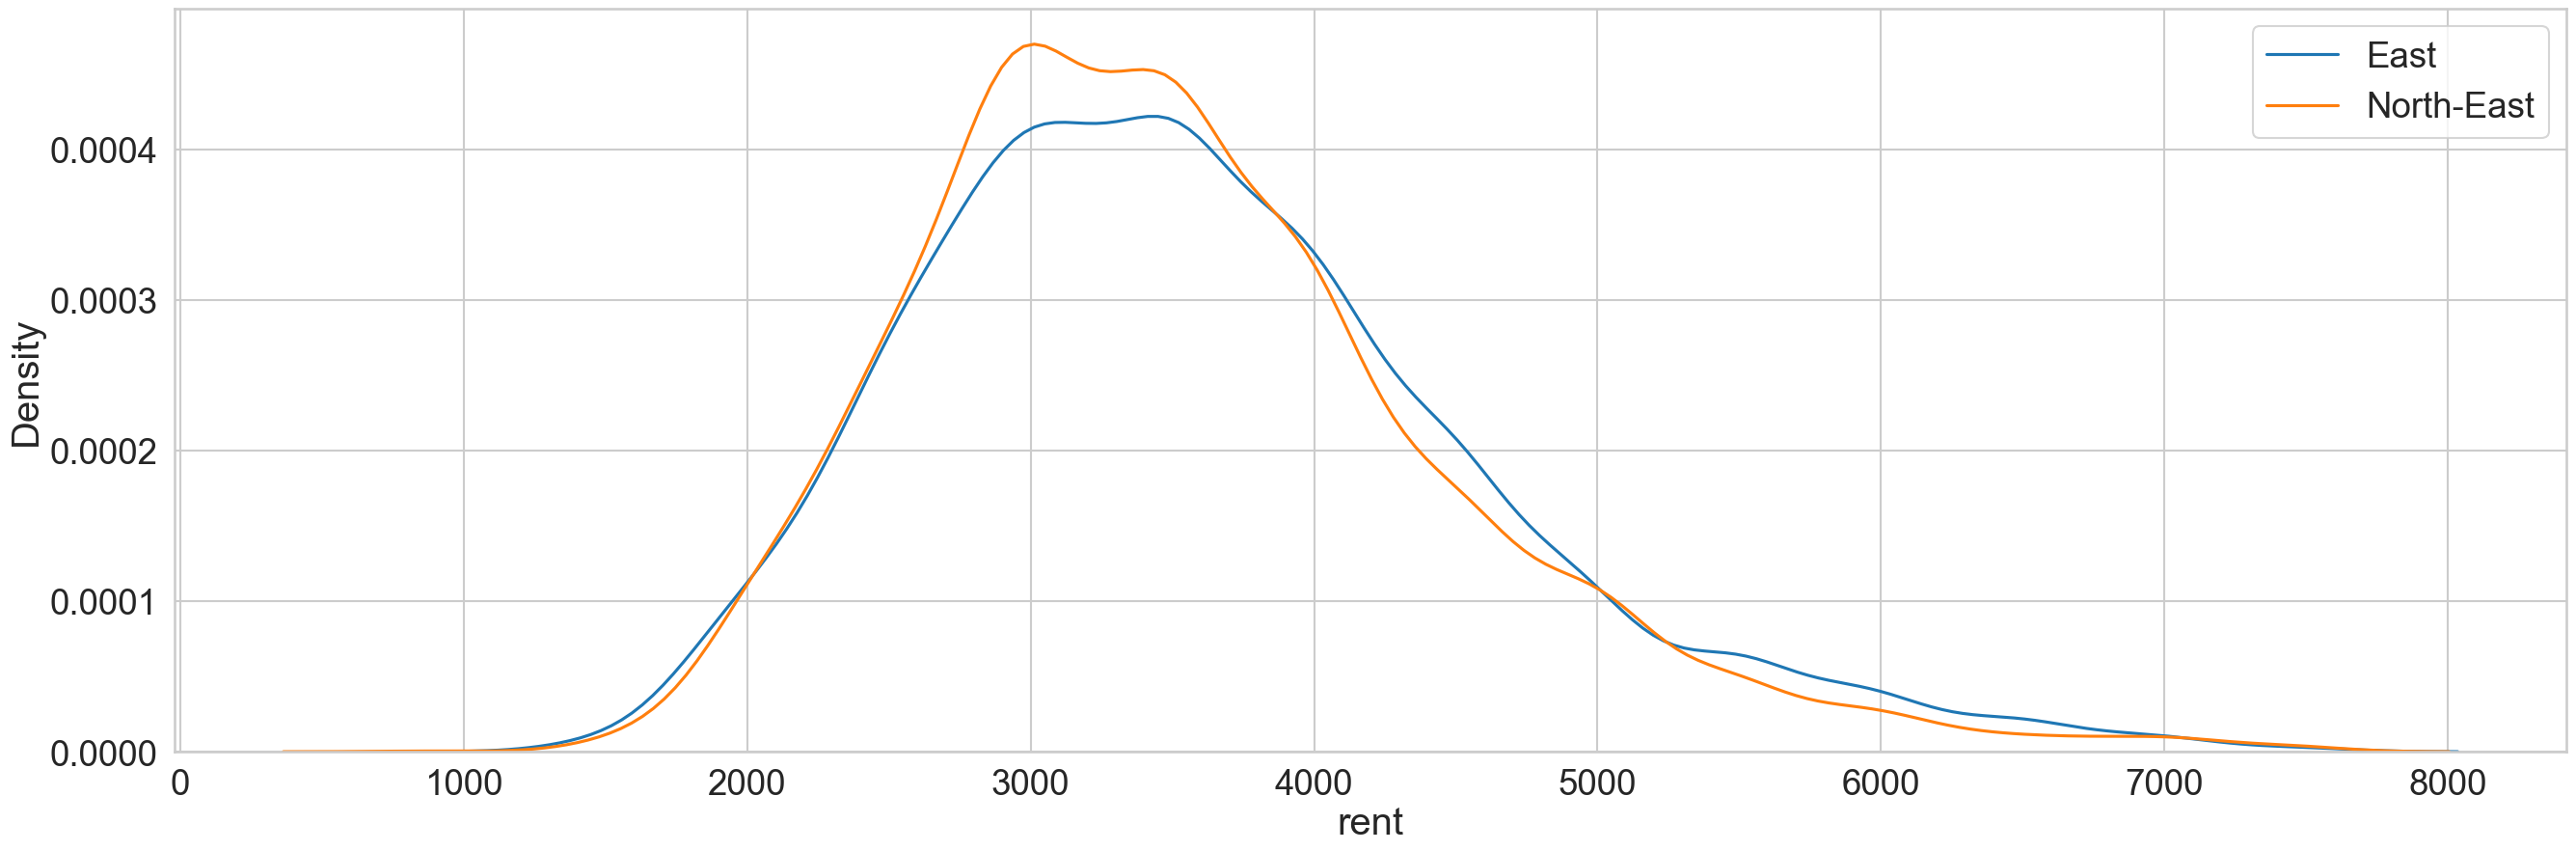

In [157]:
sns.kdeplot(e2_rent_sample, label = 'East')
sns.kdeplot(ne2_rent_sample, label = 'North-East')
plt.legend(loc='upper right')

#### varainces are not critically different

### Assess the statistical hypothesis using Student's test

In [158]:
import scipy.stats as stats

In [180]:
#Student’s t-test
st, p = stats.ttest_ind(e2_rent_sample, ne2_rent_sample)

#H0 - there's no statistically significant difference between rental costs for 2-bedroom properties in East and North-East regions
#H1 - there's statistically significant difference between rental costs for 2-bedroom properties in East and North-East regions

print('Statistic = %.3f, p = %.7f' % (st, p))

if p < 0.05:
    print("Reject the null hypothesis. Rental rates for 2-bedroom properties in the East are statistically different from those in the North-East")
else:
    print("Do not reject the null hypothesis. Rental rates for for 2-bedroom properties in the East are not significantly different from those in the North-East")

Statistic = 3.929, p = 0.0000858
Reject the null hypothesis. Rental rates for 2-bedroom properties in the East are statistically different from those in the North-East


{'whiskers': [<matplotlib.lines.Line2D at 0x1d3b797b250>,
 'caps': [<matplotlib.lines.Line2D at 0x1d3b77effd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d3a6e57dc0>,
 'medians': [<matplotlib.lines.Line2D at 0x1d3b77ec790>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d3b77ec370>,
 'means': []}

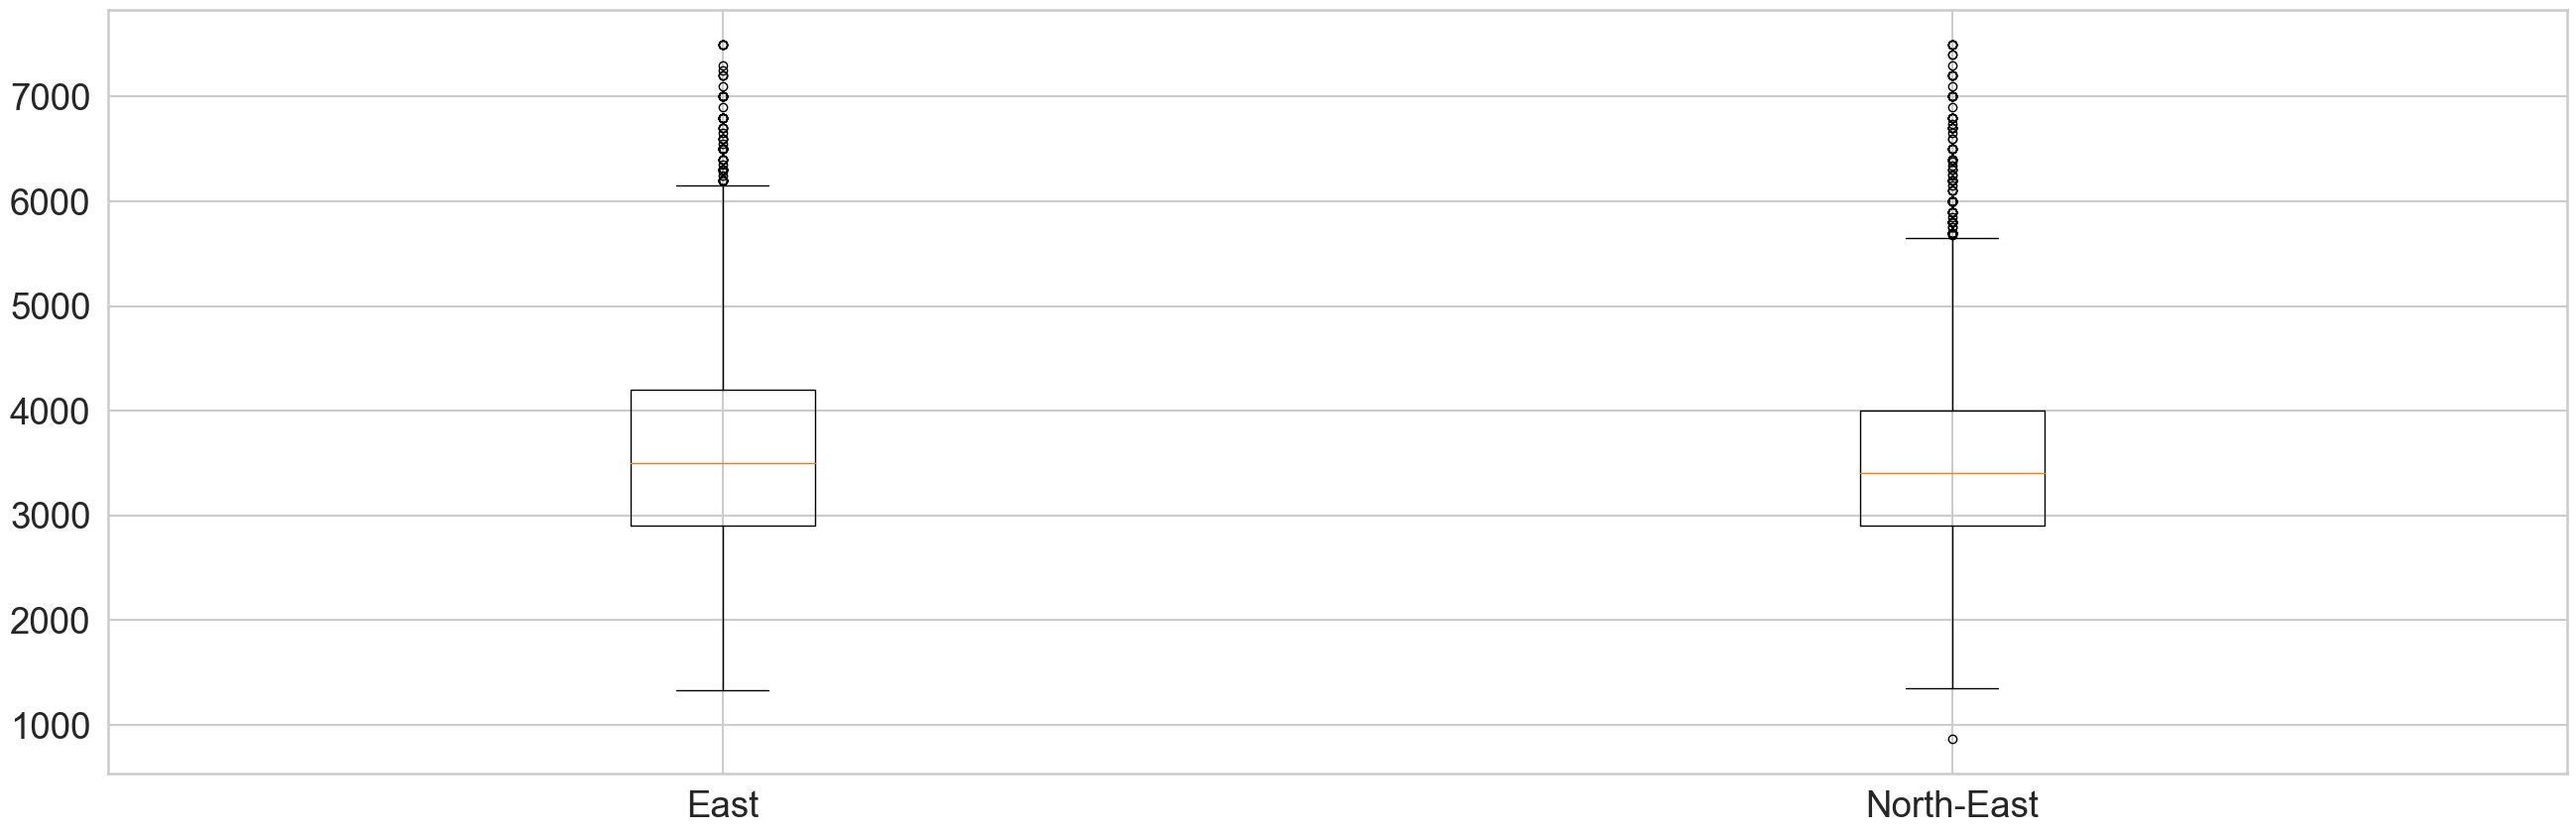

In [161]:
plt.boxplot([e2_rent_sample, ne2_rent_sample], labels = ['East', 'North-East'])

## 4. The Project Summary
#### - Available raw data from Singapore official open data services cleaned, transformed and prepared for further EDA.
#### - The analysis resulting in the identification of patterns in the prepared data as well as in various forms of visualization of key indicators. 
#### - The statistical analysis revealed trends and correlations in the context of the selected areas and types of residential property and provide us with directions for further action on the selection of housing rental options.